# Alpha Research

The goal in this project is to define a liquid universe of stocks where we would apply our factors into it to see through our factor analysis if there is a potential or not to send these results to production. After selecting and combining factors using Machine Learning technics, the combined factor is analyzed and improved with an optimizer function to integrate our risk model.  

This project workflow is comprised of distinct stages including: 

1. Parameters
2. Universe definition
3. Sector definition
4. Alpha factors
5. Factor analysis
6. Factors combination
7. Risk analysis for equal weights
8. Integrating factor data to the optimizer
9. Optimized factor analysis
10. Predicted portfolio

In this context we have used different source of data provided from 
[Sharadar](https://www.quandl.com/publishers/sharadar) and 
[IFT](https://www.quandl.com/publishers/ift) as described below:

- Sharadar Equity Prices ([SHARADAR/SEP](https://www.quandl.com/databases/SEP/data))
Updated daily,End-Of-Day (EOD) price (ohlcv) data for more than 14,000 US public companies.  
- Indicator Descriptions ([SHARADAR/INDICATORS](https://www.quandl.com/databases/SF1/data))
Description of indicators listed in SF1 table for more than 14,000 US public companies.
- Tickers and Metadata ([SHARADAR/TICKERS](https://www.quandl.com/databases/SF1/data))
Information and metadata for more than 14,000 US public companies.
- Core US Fundamentals ([SHARADAR/SF1](https://www.quandl.com/databases/SF1/data))
 150 essential fundamental indicators and financial ratios, for more than 14,000 US public companies.
- Daily Metrics ([SHARADAR/DAILY](https://www.quandl.com/databases/SF1/data))
 5 essential metrics indicators and financial ratios daily updated, for more than 14,000 US public companies.
- Sentiment Analysis and News Analytics ([IFT/NSA](https://www.quandl.com/databases/NS1/data)) 
News, blogs, social media and proprietary sources for thousands of stocks.

In [82]:
import pyfolio as pf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import zipfile
import os
import alphalens as al
import quandl
import quantstats as qs
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
from sklearn import preprocessing
import pytz
import itertools
import warnings
from time import sleep

warnings.filterwarnings("ignore")

In [3]:
import risk_model
import factorize
import account
import utils_s
import feature_weights

In [4]:
secret_key = pd.read_csv('secret_key.txt',header=None)
quandl.ApiConfig.api_key = secret_key[0][0]

# 1 - Parameters

Before diving into factor research and quantitative analysis, we have to define parameters that will be used in different stages of this project. The purpose is to try different parameters to optimize our output portfolio during the time. The first parameter we set here below is `update_data` that is used to decide if we want to update the data or not.

In [5]:
update_data = False
if update_data:
    print ('ready to update data')
else:
    print ('data is already updated') 

data is already updated


## 1 - 1 - Time series data parameters

In this part, we set date parameters which are used for calling data from Quandl API. In this context, we call SEP/SHARADAR, DAILY/SHARADAR, and IFT/NSA for three years of data and SF1/SHARADAR for four years. The reason for this slicing is related to our final factor data where we look back one year. For example, some factors window length is set to one year, which means we need to load a minimum of three years data to chunk the final data frame in one year slice.

In [6]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))

current date: 2020-07-18


In [7]:
# SF1
some_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(some_years,month,day)
print ('SF1 data starting date: {}'.format(start_f))

SF1 data starting date: 2016-7-18


In [8]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP,Daily and Sentiment data starting date: {}'.format(start_sep))

SEP,Daily and Sentiment data starting date: 2017-7-18


## 1 - 2 - Factor data period parameters

We set our final date parameter to one year factor data. The reason is that we believe more than one-year factor analysis will decrease our efficiency in prediction and could affect our interpretation of results.

In [9]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-7-18


## 1 - 3 - Universe filteration parameters

The universe filtration is an important step in this project. These parameters set here below will impact our analysis and need to be tuned as well as other parameters. `cap_select` is composed of market caps which are filtered for our universe of stocks. `filteration_number` represents the number of liquid securities selected by dollar volume function and finally `smoothing_universe_period` represents the moving average length use in dollar volume function to select liquid securities smoothed over time. We will discuss these parameters more in the next sections.

In [10]:
cap_select = ['6 - Mega', '5 - Large', '4 - Mid']
filteration_number  = 1000
smoothing_universe_period = 100

## 1 - 4 - Pipeline parameters

Creating factor data in a different way to obtain significant results is a critical subject treated in this project. The goal is to tune up the factor parameter to get optimal results. This section lets us test different parameters for these factors and navigates over different factor data. `smoothed_value` is the window length moving average parameter used to remove the noise created by factor variation. We will discuss other parameters in the factors section. 

In [11]:
smoothed_value = 5

In [12]:
fundamental_ind = ['cashneq']
momentum_in = {'momentum_252d':252}
sma_in = {'sma200':200}
daily_in = {'marketcap':100, 'evebitda':100}
over_in = {'overnight_sentiment_5d':5}
direction_in = {'direction_100d':100}
sent_in = {'sentiment_100d':100}

## 1 - 5 - Factor analysis parameters

Here below we select periods to analyze our multi-factor output. These periods are selected according to our trading strategy and portfolio management methods. The `rebalance_period` is also an important parameter to choose carefully and consider commission fees in our portfolio management system. 

We use Principal Component Analysis (PCA) in our risk management model to reduce the dimensionality of the risk factors. `factor exposures` parameter is the dimension that we want to reduce to it.

In [13]:
combined_periods = (3,5,10)
rebalance_period = 5

In [14]:
# Risk analysis
factor_exposures = 13

## 1 - 6 - Optimizer parameters

After combining factors we put it into the optimizer function which will maximize alpha factor and consider our risk model in counterpart. `risk_cap` is used to set the risk exposure parameter. More the risk is and more the alpha will be. `lambda_reg` is used regularized our optimized function. it is operating like a portfolio enhancer.

In [15]:
risk_cap = 0.05
lambda_reg = 0.5

## 1 - 7 - Sector parameters

Our factor data is preprocessed and grouped by sector. Here below we can select sectors to drop, `sec_to_drop` regrouped sectors to not appear in factor data and our analysis to avoid sectors which have poor results. We also have the choice to drop specific sectors from long universe or short universe. For example the Tehnology sector shows good results in long qunatile and poor results in short quantile, it would be interesting to add this sector to `drop_short_sec`.

In [16]:
sec_to_drop = [ 
                'Basic Materials',
                'Industrials',
                'Healthcare',
                'Financial Services',
                'Communication Services',
                'Real Estate',
                'Energy',
                'Utilities'
              ]

In [17]:
drop_long_sec = []
drop_short_sec = []

In [18]:
assert set(sec_to_drop) & set(drop_long_sec) == set()
assert set(sec_to_drop) & set(drop_short_sec) == set()
assert set(drop_long_sec) & set(drop_short_sec) == set()

## 1 - 9 - Quantiles

Here after the quantiles parameters are defining the equal portions of datas to be analyzed and considered for the future portfolio. `quantile_portions` is the number of qunatiles we want to analyze and work with. In the other hand `quantile_to_analysis` is the quantiles selected for the final analyze and portfolio. We use to select extremety quantiles to get the best results. 

In [19]:
qunatile_portions = 25
quantile_to_analyse = [1,qunatile_portions]

## 1 - 10 - Long/Short leverage 

The leverage we choose for our long/short portfolio could vary during time and market conditions. Parameters below let us choose the leverage with consideration of the total leverage which is equal to one.

In [20]:
percent_long_leverage_target = 0.6
percent_short_leverage_target = 0.4

In [21]:
assert percent_long_leverage_target + percent_short_leverage_target == 1

# 2 - Universe definition

## 2 - 1 - Get  META data

In [22]:
meta = quandl.get_table('SHARADAR/TICKERS', table='SF1',paginate=True)
meta.set_index('ticker',inplace=True, drop=True)

## 2 - 1 - 1 - First universe filteration

In [23]:
meta_ex = meta[(meta['exchange'] == 'NYSE') ^ (meta['exchange'] == 'NASDAQ')]
cap = []
for i in cap_select:
    cap.append(list(meta_ex[(meta_ex['scalemarketcap'] == i)].index))
meta_ex_sc = meta_ex.loc[list(itertools.chain.from_iterable(cap))]    
meta_ex_sc_cu = meta_ex_sc[(meta_ex_sc['currency'] == 'USD') & (meta_ex_sc['isdelisted'] == 'N')]

In [24]:
u1 = list(meta_ex_sc_cu.index)

In [25]:
print ('{} companies selected in first filteration'.format(len(u1)))

1982 companies selected in first filteration


## 2 - 2 - Get two years data for SEP

In [26]:
if update_data:
    quandl.export_table('SHARADAR/SEP',
                        ticker=u1, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename = 'data/ohlcv.zip')

In [27]:
with zipfile.ZipFile('data/ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


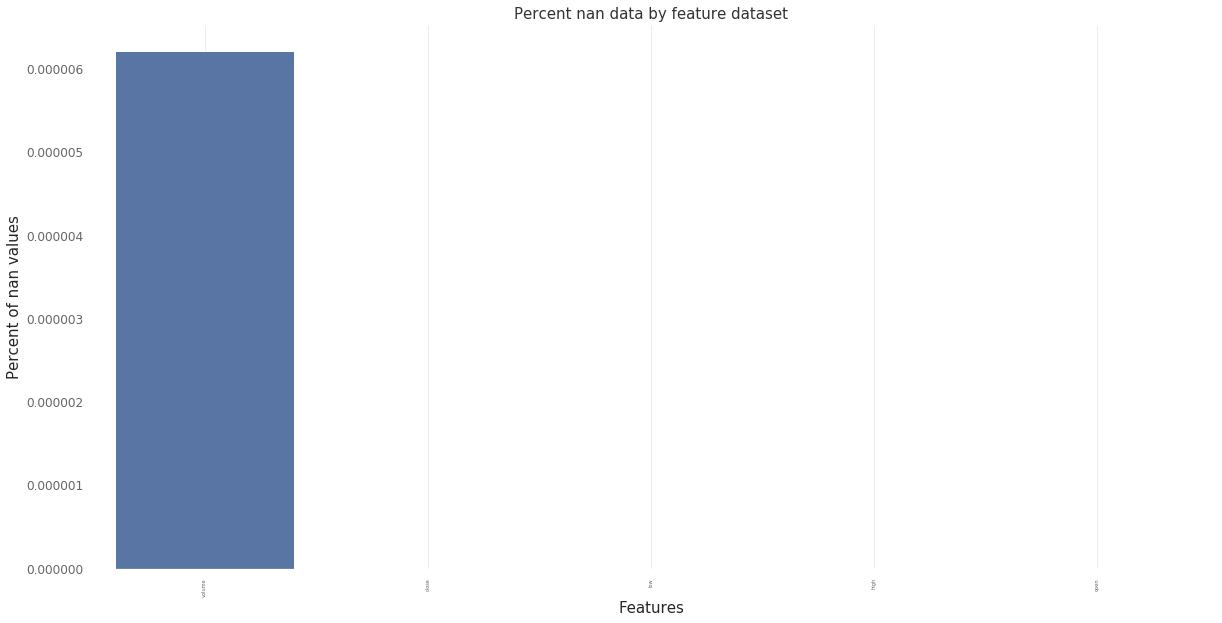

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [28]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

### 2 - 2 - 1 - Second universe filteration using Market Capitalization 

In [29]:
def dollar_volume_universe(tickers_num, ohlcv, sma_period):
    
    ohlcv['dollar_volume'] = ohlcv['close']*ohlcv['volume']
    dollar_vol = ohlcv['dollar_volume'].unstack('ticker')
    sma = pd.DataFrame(index = dollar_vol.index)
    try:
        for tick in dollar_vol.columns:
            sma[tick] = talib.SMA(dollar_vol[tick].values, timeperiod=sma_period)
    except:
        pass
    
    last = sma.iloc[-1,:]
    dol = pd.DataFrame(data = last.values,index = last.index, columns = ['dv'])
    dol.dropna(inplace = True)
    
    return list(dol.sort_values(by='dv', ascending=False).iloc[:tickers_num].index)    

In [30]:
universe = dollar_volume_universe(tickers_num = filteration_number, ohlcv = ohlcv, sma_period = smoothing_universe_period)

In [31]:
print ('{} companies selected out of {} for second filteration'.format(len(universe),len(u1)))

1000 companies selected out of 1982 for second filteration


#### Sector filteration

In [32]:
universe_sectors = pd.DataFrame(index=universe, columns=['sectors'])
for i in universe:
    universe_sectors.loc[i] = meta_ex_sc_cu.loc[i]['sector']
    
    for sec in sec_to_drop:
        if meta_ex_sc_cu.loc[i]['sector'] == sec:
            universe_sectors.drop(i, axis=0,inplace=True)

In [33]:
universe = list(universe_sectors.index)

In [34]:
print ('{} companies selected after sector drop out of {} for second filteration'.format(len(universe),len(u1)))

414 companies selected after sector drop out of 1982 for second filteration


## 2 - 3 - Get three years data for SF1

In [35]:
if update_data:
    #qopts={"columns":ind}
    quandl.export_table('SHARADAR/SF1',
                        ticker=universe, 
                        dimension = 'MRQ', 
                        calendardate={'gte':start_f,'lte':str(tod)}, 
                        filename='data/fundamental.zip')

In [36]:
with zipfile.ZipFile('data/fundamental.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SF1':
        sf1 = pd.read_csv(item)
        sf1 = sf1.set_index(['calendardate', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sf1.drop(['datekey','reportperiod','lastupdated','dimension'],axis=1,inplace=True)
        os.remove(item)  

In [37]:
print ('the following tickers are not loaded in sf1:\n {}'.format(list(sf1.index.levels[1] ^ universe)))
print ('{} securities loaded out of {}'.format(len(sf1.index.levels[1]), len(universe)))

the following tickers are not loaded in sf1:
 ['BUD', 'CHKP', 'DOX', 'GDS', 'GLOB', 'INFY', 'MGA', 'MLCO', 'MTCH', 'NICE', 'STM', 'WB']
402 securities loaded out of 414


### 2 - 3 - 1 - Cleaning data

cleaning data
columns are clean


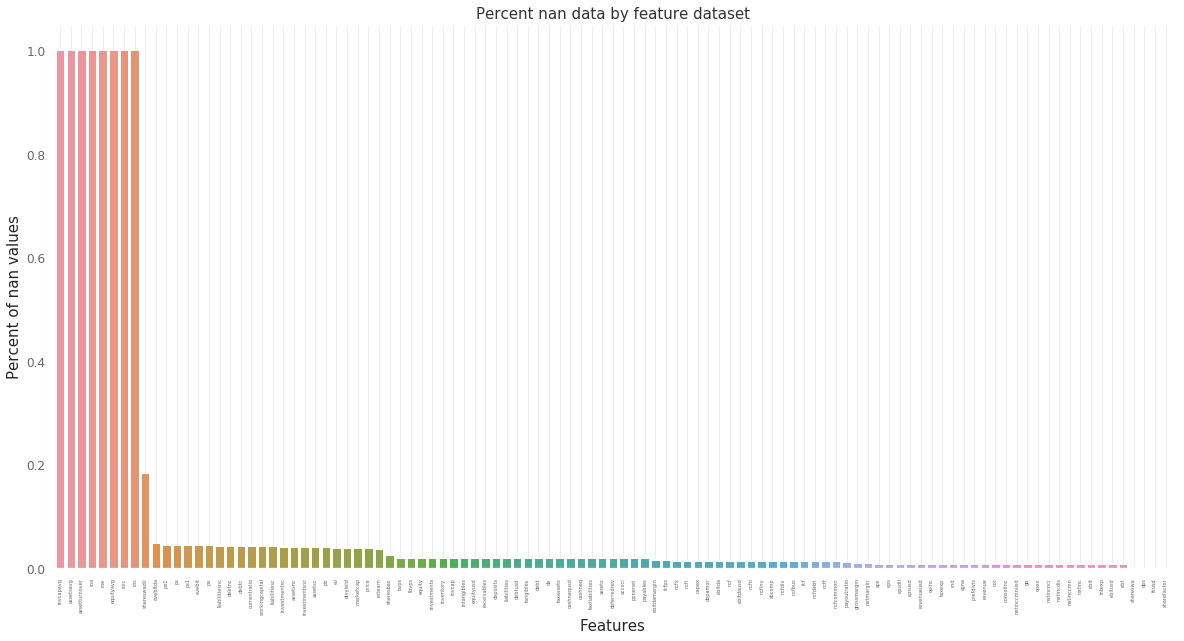

The percentage of dropped columns is 7%.
Dropped 8 columns out of 105


In [38]:
sf1 = utils_s.cleaning_dataframe(sf1,0.2)

In [39]:
sf1['roe'] = sf1['netinc'] / sf1['equity']
sf1['roa'] = sf1['netinc'] / sf1['assets']
sf1['fcf_yield'] = sf1['fcf'] / sf1['ev']

## 2 - 4 - Get two years data for DAILY

In [40]:
if update_data:
    quandl.export_table('SHARADAR/DAILY',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/daily.zip')

In [41]:


with zipfile.ZipFile('data/daily.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'DAILY':
        daily = pd.read_csv(item)
        daily['date'] = pd.to_datetime(daily['date'])
        daily = daily.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        daily.drop(['lastupdated'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


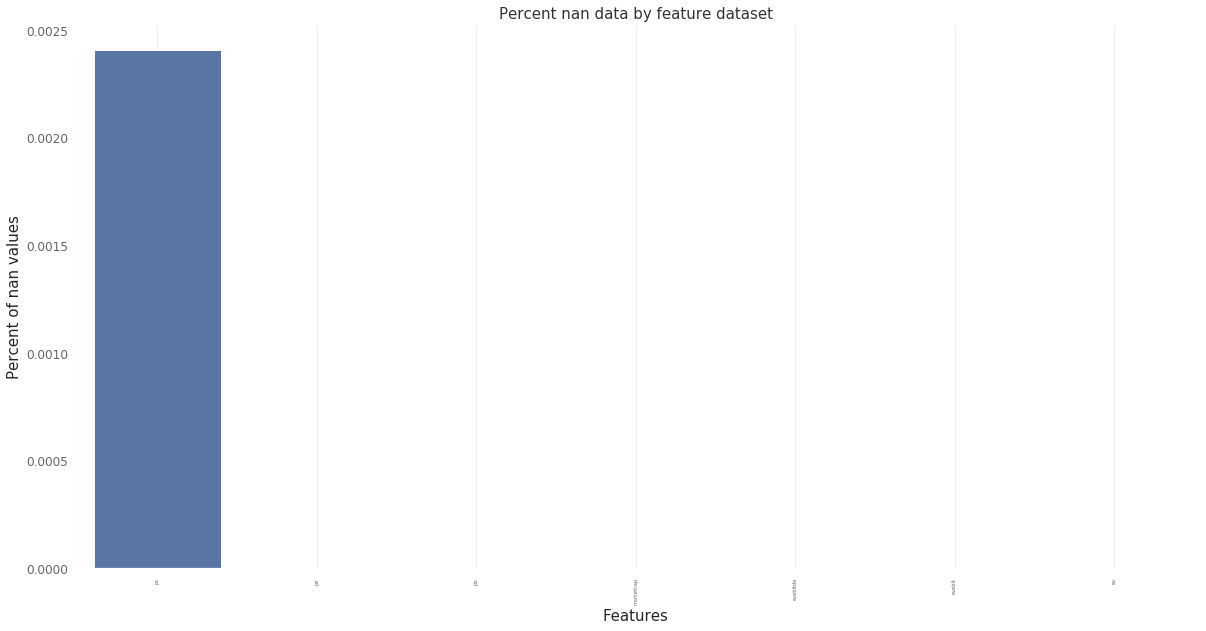

The percentage of dropped columns is 0%.
Dropped 0 columns out of 7


In [42]:
daily = utils_s.cleaning_dataframe(daily,0.2)

## 2 - 4 - Get two years data for SENTIMENT

In [43]:
if update_data:
    quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'
    quandl.export_table('IFT/NSA',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/sent.zip')

In [44]:
with zipfile.ZipFile('data/sent.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'IFT' and item.split('_')[1] == 'NSA':
        sent = pd.read_csv(item)
        sent['date'] = pd.to_datetime(sent['date'])
        sent = sent.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sent = sent[sent['exchange_cd']=='US']
        sent.drop(['name','exchange_cd'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


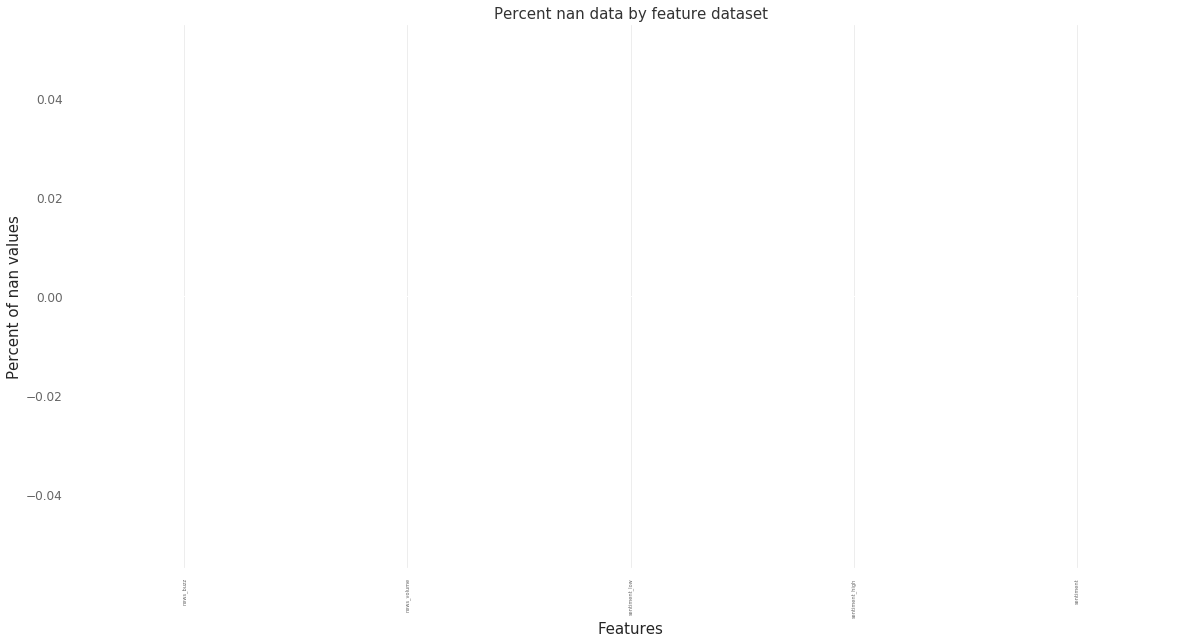

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [45]:
sent = utils_s.cleaning_dataframe(sent,0.2)

### Universe intersection

In [46]:
new_universe =list(set(sent['sentiment'].unstack('ticker').columns) & set(sf1.index.levels[1]) & set(daily.index.levels[1]) & set(ohlcv.index.levels[1]))

In [47]:
print ('final universe has {} stocks'format(len(new_universe)))

373

# 3 - Sector definition

In [48]:
meta_cleaned = meta_ex_sc_cu.loc[new_universe,:]

In [49]:
print ('Sectors in filtered data: \n')
sectors = {}
for i in set(meta_cleaned['sector']):
    print (' ',i)
    sectors[i] = list(meta_cleaned[meta_cleaned['sector'] == i].index)

Sectors in filtered data: 

  Technology
  Consumer Defensive
  Consumer Cyclical


# 4 - Alpha factors

## 4 - 1 - Factorizing

In [50]:
close = ohlcv['close'].unstack('ticker')[new_universe]
openn = ohlcv['open'].unstack('ticker')[new_universe]
high = ohlcv['high'].unstack('ticker')[new_universe]
low = ohlcv['low'].unstack('ticker')[new_universe]

In [52]:
pricing = openn.loc[slice(start,end),:].tz_localize('UTC')[new_universe]

In [53]:
# daily

daily_data = {}

for i in daily_in.keys():
    
    df_daily = daily[i].unstack('ticker')
    reversion = factorize.Momentum(df_daily,daily_in[i])*-1
    smoothed_reversion = factorize.Smooth(reversion,smoothed_value)
    smoothed_reversion_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_reversion),
                                                     index = smoothed_reversion.index,
                                                     columns = smoothed_reversion.columns)
    smoothed_reversion_scaled.index = pd.to_datetime(smoothed_reversion_scaled.index)
    smoothed_reversion_scaled = smoothed_reversion_scaled.loc[slice(start,end),:]

    result = []
    for sec in sectors.keys():
        result.append(smoothed_reversion_scaled[sectors[sec]].sub(smoothed_reversion_scaled[sectors[sec]].mean(axis=1),axis=0))

    smoothed_reversion_neutralized_scaled = pd.concat(result,axis=1)
#     smoothed_reversion_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_reversion_neutralized),
#                                                          index = smoothed_reversion_neutralized.index,
#                                                          columns = smoothed_reversion_neutralized.columns)
    
    daily_data[i] = smoothed_reversion_neutralized_scaled


In [54]:
# SMA
sma_data = {}

for name,period in sma_in.items():

    df= pd.DataFrame(index = close.index)

    try:
        for tick in close.columns:
            df[tick] = talib.SMA(close[tick].values, timeperiod=period)
    except:
        pass

    sma_min = (close - df)*-1
    smoothed_sma_min = factorize.Smooth(sma_min,smoothed_value)
    smoothed_sma_min.index = pd.to_datetime(smoothed_sma_min.index)
    smoothed_sma_min = smoothed_sma_min.loc[slice(start,end),:]
    
    # Neutralizing by sector
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sma_min[sectors[sec]].sub(smoothed_sma_min[sectors[sec]].mean(axis=1),axis=0))

    smoothed_sma_min_neutralized = pd.concat(result,axis=1)    
    
    smoothed_sma_min_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_sma_min_neutralized),
                                                              index = smoothed_sma_min_neutralized.index,
                                                              columns = smoothed_sma_min_neutralized.columns)
    
    sma_data[name] = smoothed_sma_min_neutralized_scaled
    

In [55]:
over_data = {}

for name,period in over_in.items():
    overnight_sentiment = factorize.overnight_sentiment(close, openn, window_length=1, trailing_window=period)*-1
    smoothed_overnight_sentiment = factorize.Smooth(overnight_sentiment,smoothed_value)
    
    smoothed_overnight_sentiment.index = pd.to_datetime(smoothed_overnight_sentiment.index)
    
    smoothed_overnight_sentiment = smoothed_overnight_sentiment.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_overnight_sentiment[sectors[sec]].sub(smoothed_overnight_sentiment[sectors[sec]].mean(axis=1),axis=0))

    smoothed_overnight_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    over_data[name] = smoothed_overnight_sentiment_neutralized_scaled
    

In [56]:
# mean reversion
momentum_data = {}

for name,period in momentum_in.items():
    
    mean_reversion = factorize.Momentum(close,period)*-1
    smoothed_mean_reversion = factorize.Smooth(mean_reversion,smoothed_value)
    
    smoothed_mean_reversion.index = pd.to_datetime(smoothed_mean_reversion.index)
    smoothed_mean_reversion = smoothed_mean_reversion.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_mean_reversion[sectors[sec]].sub(smoothed_mean_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_mean_reversion_neutralized_scaled = pd.concat(result,axis=1)
  
    momentum_data[name] = smoothed_mean_reversion_neutralized_scaled


In [57]:
# direction
direction_data = {}

for name,period in direction_in.items():
    
    direct = factorize.direction(close, openn, 1, period)
    smoothed_direct = factorize.Smooth(direct,smoothed_value)

    smoothed_direct.index = pd.to_datetime(smoothed_direct.index)
    smoothed_direct = smoothed_direct.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_direct[sectors[sec]].sub(smoothed_direct[sectors[sec]].mean(axis=1),axis=0))

    smoothed_direct_neutralized_scaled = pd.concat(result,axis=1)
    
    direction_data[name] = smoothed_direct_neutralized_scaled

In [58]:
# sentiment
sent_data = {}

for name,period in sent_in.items():
    
    sentiment = factorize.sentiment(close, high, low, sent, period, new_universe)
    smoothed_sentiment= factorize.Smooth(sentiment,smoothed_value)
    smoothed_sentiment.index = pd.to_datetime(smoothed_sentiment.index)
    smoothed_sentiment = smoothed_sentiment.loc[slice(start,end),:]
    
#     to_drop = smoothed_sentiment.columns ^ close.columns

#     for i in to_drop:
#         sectors[meta_cleaned.loc[i]['sector']].remove(i)
        
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sentiment[sectors[sec]].sub(smoothed_sentiment[sectors[sec]].mean(axis=1),axis=0))
    
    smoothed_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    sent_data[name] = smoothed_sentiment_neutralized_scaled

## 4 - 2 - Fundamentals 

### 4 - 2 - 1 - Indicators

In [59]:
#indicator=ind
indicators_desc = quandl.get_table('SHARADAR/INDICATORS')
sf1_ind = indicators_desc[indicators_desc['table']=='SF1']

In [60]:
# Columns description of cleaned SF1
for i in sf1.columns:
    try:
        print (i,':',sf1_ind[sf1_ind['indicator']==i]['title'].values[0],':',sf1_ind[sf1_ind['indicator']==i]['description'].values[0],'\n')
    except:
        pass

accoci : Accumulated Other Comprehensive Income : [Balance Sheet] A component of [Equity] representing the accumulated change in equity from transactions and other events and circumstances from non-owner sources; net of tax effect; at period end. Includes foreign currency translation items; certain pension adjustments; unrealized gains and losses on certain investments in debt and equity securities. 

assets : Total Assets : [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables]. 

assetsc : Current Assets : [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets. 

assetsnc : Assets Non-Current : [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total As

taxexp : Income Tax Expense : [Income Statement] Amount of current income tax expense (benefit) and deferred income tax expense (benefit) pertaining to continuing operations. 

taxliabilities : Tax Liabilities : [Balance Sheet] A component of [Liabilities] representing outstanding tax liabilities. 

tbvps : Tangible Assets Book Value per Share : [Metrics] Measures the ratio between [Tangibles] and [SharesWA] as adjusted by [ShareFactor]. 

workingcapital : Working Capital : [Metrics] Working capital measures the difference between [AssetsC] and [LiabilitiesC]. 

roe : Return on Average Equity : [Metrics] Return on equity measures a corporation's profitability by calculating the amount of [NetIncCmn] returned as a percentage of [EquityAvg]. 

roa : Return on Average Assets : [Metrics] Return on assets measures how profitable a company is [NetIncCmn] relative to its total assets [AssetsAvg]. 



### 4 - 2 - 2 - Factorizing, Neutralizing and Resampling

In [61]:
data = {}
for i in fundamental_ind:
    
    df = sf1[i].unstack('ticker')[new_universe]
    df.fillna(df.mean(axis=0),inplace=True)
    
    # Calculating Return
    returns = factorize.Returns(df,window_length=1)
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)    
    
    returns_drz = pd.DataFrame(data = preprocessing.scale(returns),
                               index = returns.index,
                               columns = returns.columns) 

    result = []
    for sec in sectors.keys():
        result.append(returns_drz[sectors[sec]].sub(returns[sectors[sec]].mean(axis=1),axis=0))
    
    returns_neutralize = pd.concat(result,axis=1)

    # Resampling
    chunk = (ohlcv.index.levels[0][-1]+datetime.timedelta(days=1)).date()
    chunk_minus = ohlcv.index.levels[0][-1].date()
    returns_neutralize.loc[chunk,:] = np.nan
    returns_neutralize.index = pd.to_datetime(returns_neutralize.index)
    returns_neutralize_resampled = returns_neutralize.resample('D').pad()
    returns_neutralize_resampled = returns_neutralize_resampled.loc[start_sep:chunk_minus,:]
    
    # Drop holidays
    holidays = returns_neutralize_resampled.index ^ ohlcv.index.levels[0]
    returns_neutralize_resampled.drop(list(holidays),axis=0,inplace = True)
    returns_neutralize_resampled.index.name = ohlcv.index.levels[0].name
    
    # Slicing 1 year
    returns_neutralize_resampled_1y = returns_neutralize_resampled.loc[slice(start,end),:]

    data[i] = returns_neutralize_resampled_1y

## 4 - 4 - Multiindex factors

In [62]:
result = []

for ind in fundamental_ind:
    
    fund_return_neutralized_stacked = data[ind].stack().to_frame(ind)
    result.append(fund_return_neutralized_stacked)

for i in daily_in.keys():

    daily_stacked = daily_data[i].stack().to_frame('daily_{}{}days'.format(i,daily_in[i]))
    result.append(daily_stacked)

for i in sma_data.keys():

    sma_stacked = sma_data[i].stack().to_frame('sma{}'.format(sma_in[i]))
    result.append(sma_stacked)

for i in momentum_data.keys():
    
    momentum_stacked = momentum_data[i].stack().to_frame('momentum{}days'.format(momentum_in[i]))
    result.append(momentum_stacked)
    
for i in over_data.keys():
    
    over_stacked = over_data[i].stack().to_frame('overnight_sent{}days'.format(over_in[i]))
    result.append(over_stacked)    

for i in direction_data.keys():
    
    direct_stacked = direction_data[i].stack().to_frame('direction{}days'.format(direction_in[i]))
    result.append(direct_stacked)

for i in sent_data.keys():
    
    sent_stacked = sent_data[i].stack().to_frame('sentiment{}days'.format(sent_in[i]))
    result.append(sent_stacked)    
    
all_factors = pd.concat(result,axis=1)

all_factors.index = all_factors.index\
                               .set_levels([all_factors.index.levels[0].tz_localize('UTC'), all_factors.index.levels[1]])
#all_factors.dropna(axis=0, inplace = True)
all_factors

cashneq  daily_marketcap100days  \
date                      ticker                                     
2019-07-18 00:00:00+00:00 SNAP    0.688772               -0.685876   
                          GRUB    1.514277                0.271585   
                          APPN    0.372966                0.767303   
                          CERN    0.797523               -1.721550   
                          MELI   -0.292459               -1.455706   
                          ATVI   -0.030615               -0.147065   
                          FLT     0.401817               -0.598677   
                          WDAY   -0.309099               -0.221428   
                          PANW   -1.096853                0.721413   
                          SABR   -0.590251               -0.140138   
                          CDLX   -0.118477               -0.477795   
                          RNG     0.151386                0.943992   
                          QTWO    0.884399               -0.301374   
                          AVGO    0.042822                0.268223   
                          ORCL    1.092837               -0.932009   
                          SQ      0.438320                0.390817   
                          CYBR    0.332007               -0.531324   
                          COMM    1.258426                1.040579   
                          APH     0.185395               -0.124045   
                          STX     1.547473                0.266526   
                          NTNX   -0.152977                2.286506   
                          EA     -1.539509                0.526648   
                          TRMB    0.296258               -0.557024   
                          ADSK    0.480820                0.239245   
                          GOOGL  -0.779601                0.386221   
                          MSI     0.498668               -0.640104   
                          ADBE    0.498221               -0.227590   
                          EBAY   -0.224433               -0.158253   
                          BKI     0.127326               -0.823278   
                          CREE    1.271683               -0.093930   
...                                    ...                     ...   
2020-07-17 00:00:00+00:00 TOL     1.067531                0.477898   
                          GPC     0.402768               -0.136795   
                          KMX     1.415214               -0.476467   
                          LEG    -0.980117               -0.225839   
                          CHDN   -2.534866                0.627448   
                          UONE    0.230484               -3.668159   
                          CMCSA  -0.320899               -0.113685   
                          WH      0.265331                0.265534   
                          CPRI   -1.550240               -0.075129   
                          HOG    -1.265385               -0.434810   
                          CNK     1.114986                0.975366   
                          PII    -2.481015               -1.299981   
                          NKE     2.029731                0.084736   
                          ALSN    1.783653                0.711106   
                          DKS    -2.909283               -0.716272   
                          FL      0.425186                0.043551   
                          WHR    -2.410233               -1.013634   
                          WEN     0.967626                0.045744   
                          UAA    -1.909897                0.396528   
                          GPS     1.826739               -0.264257   
                          DISH    0.917898               -0.221023   
                          FBHS   -0.083532               -0.711507   
                          RL     -0.874591                1.277747   
                          CCK     0.868977                0.254889   
                          SIRI    1.790644   

In [63]:
all_factors.isna().sum()

cashneq                   0
daily_marketcap100days    0
daily_evebitda100days     0
sma200                    0
momentum252days           0
overnight_sent5days       0
direction100days          0
sentiment100days          0
dtype: int64

# 5 - All factors analysis

In [64]:
print ('Rebalance period set to {} days for factor analysis'.format(rebalance_period))

Rebalance period set to 5 days for factor analysis


In [65]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                          prices=pricing, 
                                                          periods=[rebalance_period], 
                                                          quantiles=5,
                                                          filter_zscore=20,
                                                          max_loss=0.35)
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% en

### 5 - 1 - Cumulated factor return

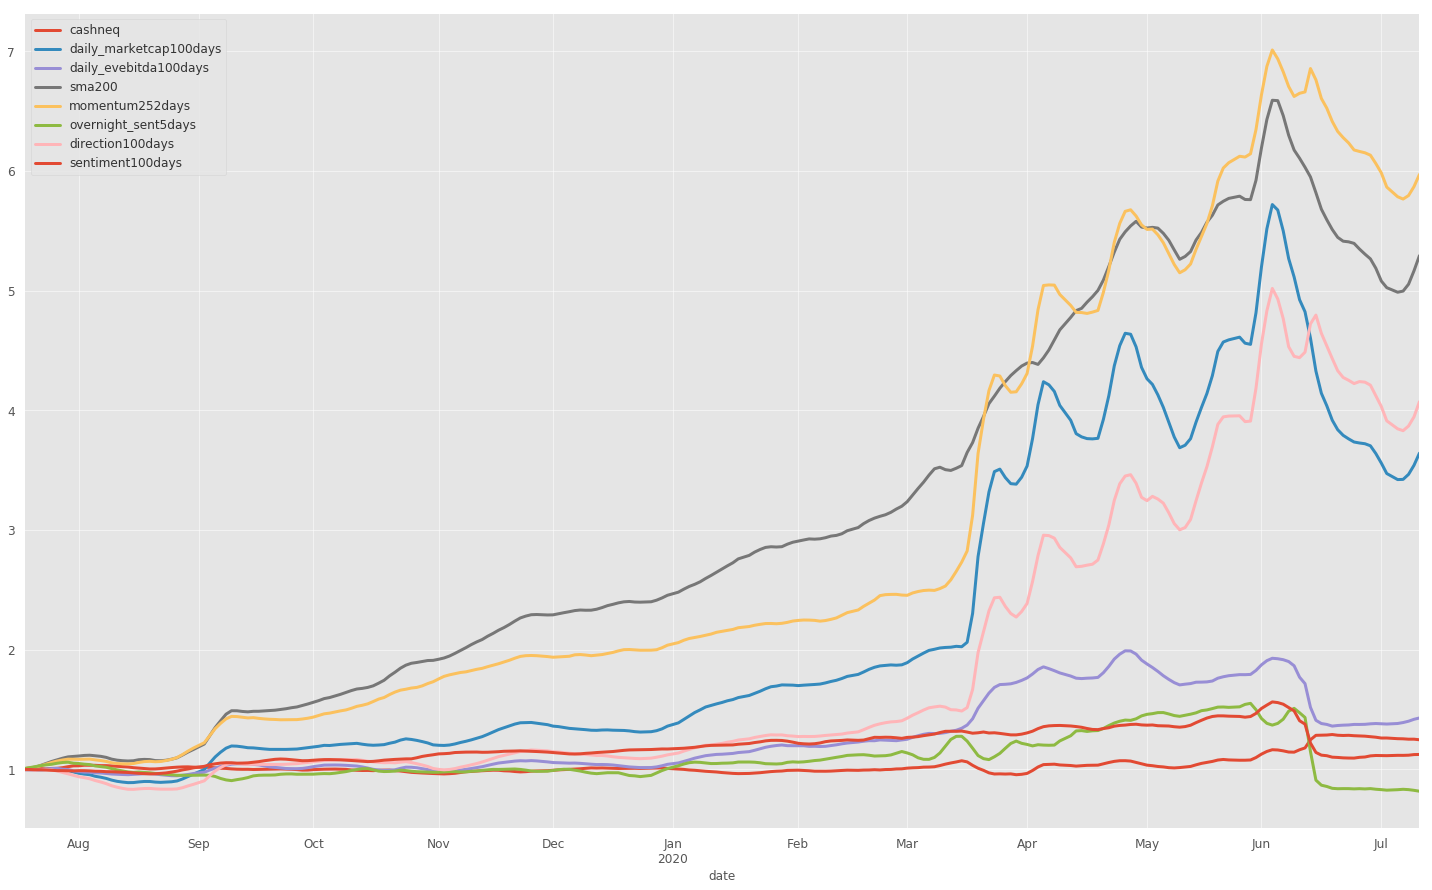

In [66]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 15)

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot(lw=3);

### 5 - 2 - Quantile analysis

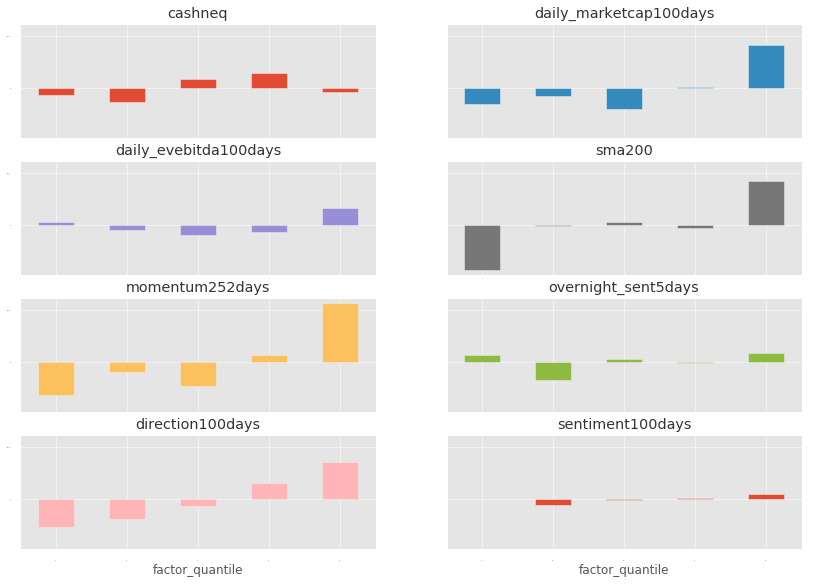

In [67]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(20,2),
    figsize=(14, 50),
    legend=False, fontsize=2);

### 5 - 3 - Factor Rank Autocorrelation

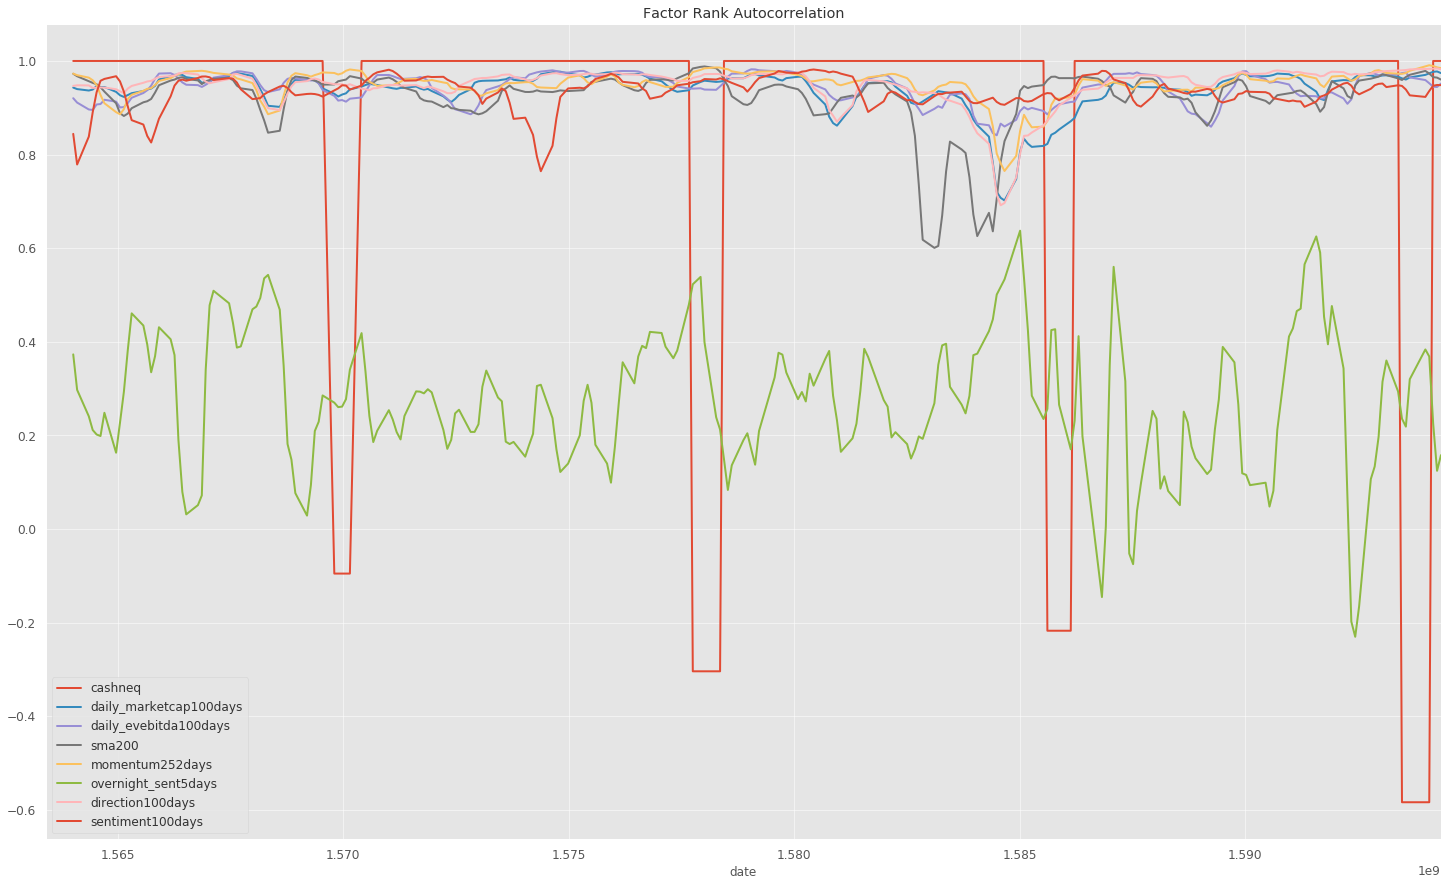

In [68]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data,period=rebalance_period)

ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

### 5 - 4 - Sharpe ratio

In [69]:
def sharpe_ratio(factor_returns, annualization_factor):

    df_sharpe = pd.Series(annualization_factor*factor_returns.mean()/factor_returns.std())
    
    return df_sharpe

In [70]:
daily_annualization_factor = np.sqrt(252)
df_sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [71]:
df_sharpe.sort_values(ascending=False)

sma200                    9.25
momentum252days           6.27
direction100days          3.83
daily_marketcap100days    3.43
cashneq                   1.94
daily_evebitda100days     1.75
sentiment100days          0.79
overnight_sent5days      -0.37
dtype: float64

# 6 - Combined factors

## 6 - 1 - Combining selceted factors

In [72]:

selected_factors = [
                         'sma200',
                         'daily_marketcap100days',
                         'direction100days',
                         'momentum252days',
                         'sentiment100days',
                         'cashneq'
                   ]

print('Selected Factors:\n{} '.format(',\n'.join(selected_factors)))

all_factors = all_factors[selected_factors]

Selected Factors:
sma200,
daily_marketcap100days,
direction100days,
momentum252days,
sentiment100days,
cashneq 


Time to train full ML pipline: 1.9827027320861816 secs
Accuracy on train set = 50.65%
Predictions: [-1. -1. -1. ... -1. -1. -1.]
Probabilities of class == 1: [49.99994115 49.99994115 49.99994115 ... 49.99994115 49.99994115
 49.99994115]
Accuracy on test set = 50.13%
Log-loss = 0.69315


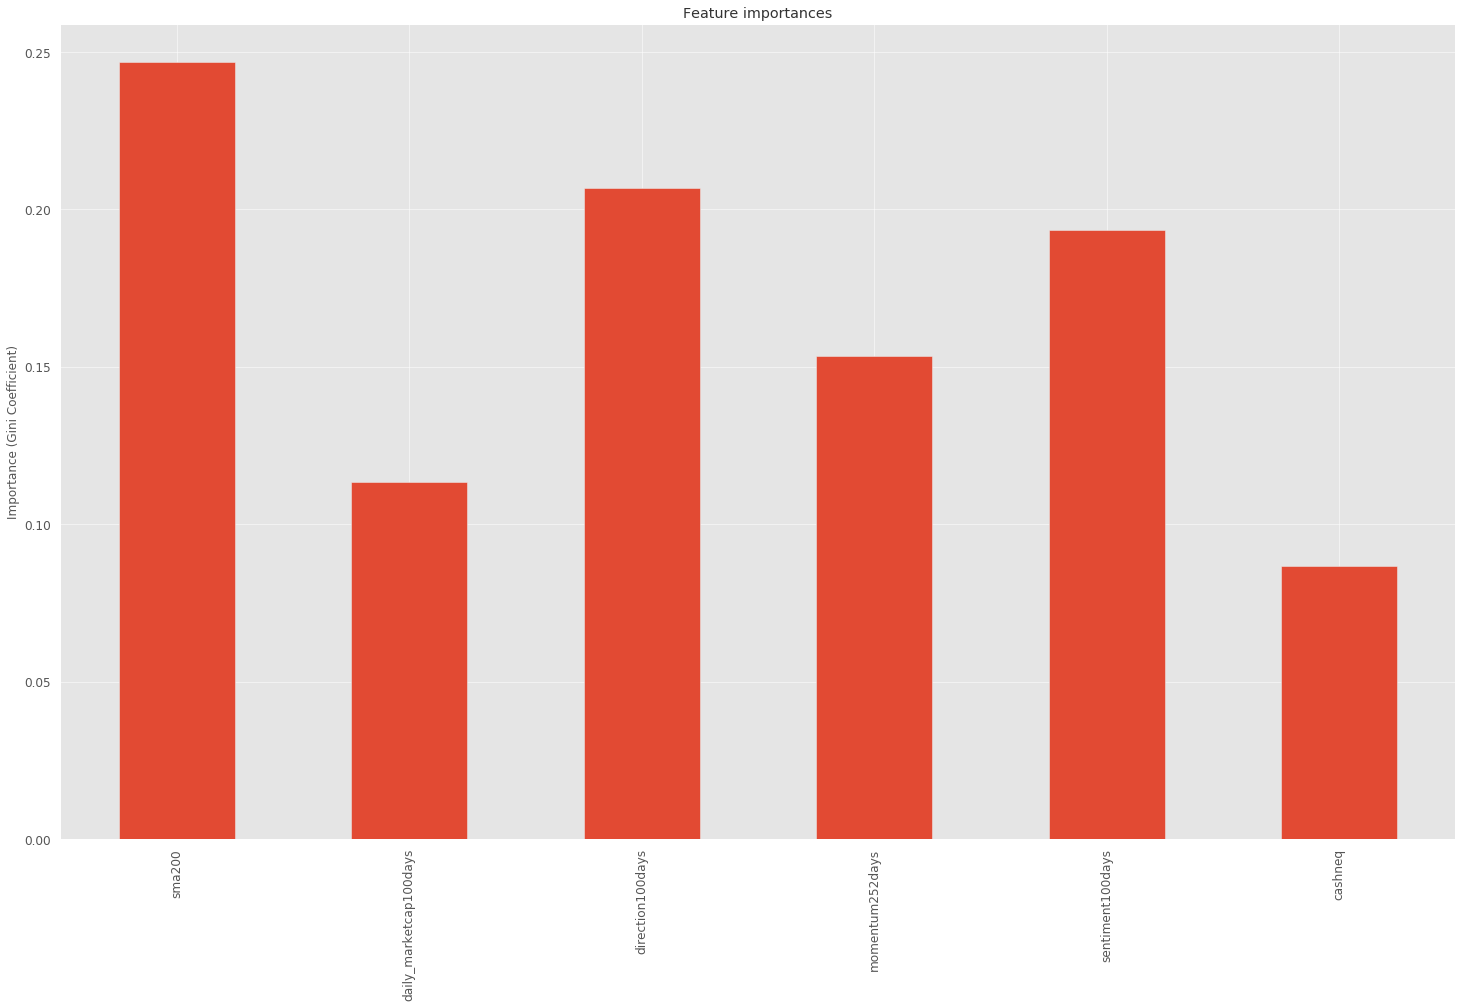

In [73]:
feature_importances = feature_weights.feature_importance(n_fwd_days = rebalance_period, 
                                                         close = close, 
                                                         all_factors = all_factors)

In [74]:
feature_importances

weights
factors                         
sma200                  0.246667
daily_marketcap100days  0.113333
direction100days        0.206667
momentum252days         0.153333
sentiment100days        0.193333
cashneq                 0.086667

In [75]:
all_factors_copy = all_factors.copy() 

In [76]:
for factor in selected_factors:
    all_factors_copy.loc[:,factor] = feature_importances.loc[factor][0] * all_factors.loc[:,factor]
all_factors_copy.loc[:,'alpha_vector'] = all_factors.sum(axis=1)
all_factors = all_factors_copy  

In [77]:
vec = pd.DataFrame(data=all_factors['alpha_vector'],columns = ['alpha_vector','sector'])
for date in vec.index.levels[0]:
    vec.loc[date,['sector']] = meta_ex_sc_cu.loc[vec.index.levels[1]]['sector'].values
sectors = vec['sector']

In [78]:
vec.shape

(94369, 2)


## 6 - 2 - Creating clean factor data

In [79]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = all_factors['alpha_vector'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = qunatile_portions,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 6 - 3 - Creating tear sheets 

In [83]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period='{}D'.format(rebalance_period),
                                       capital=10000,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       #quantiles=[1,2,4,5],
                                       groups=sectors,
                                       benchmark_period='{}D'.format(rebalance_period))

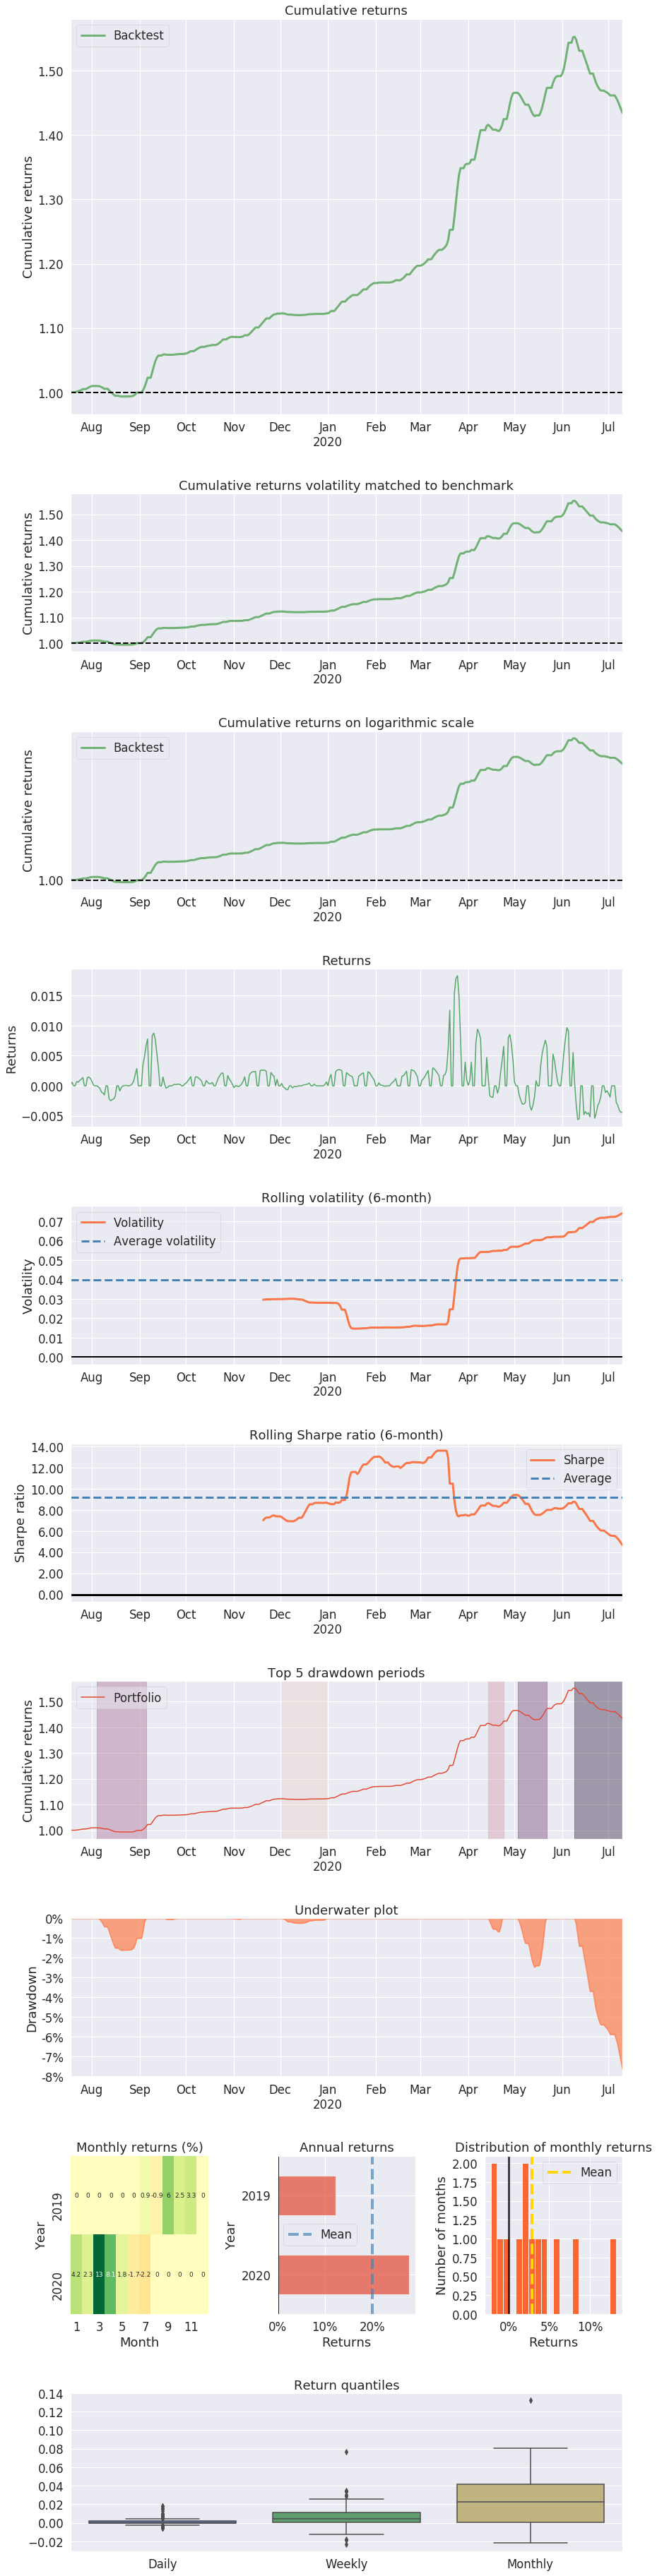

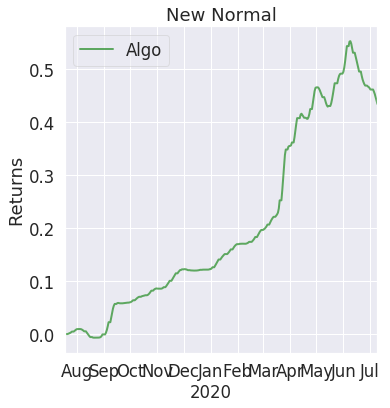

In [84]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min        max      mean       std  count   count %
factor_quantile                                                           
1               -13.794275  -3.797878 -6.288731  1.484882   3645  4.021448
2                -8.367113  -2.752889 -4.579473  1.007512   3645  4.021448
3                -7.164320  -2.184739 -3.805849  0.888055   3645  4.021448
4                -6.286177  -1.725275 -3.255324  0.845385   3645  4.021448
5                -5.433190  -1.428734 -2.768226  0.764646   3645  4.021448
6                -4.881699  -1.161838 -2.331736  0.674280   3645  4.021448
7                -4.357771  -0.839317 -1.941971  0.585951   3645  4.021448
8                -3.801865  -0.543414 -1.576104  0.490097   3645  4.021448
9                -3.227364  -0.371187 -1.258723  0.432040   3402  3.753351
10               -2.942893  -0.086126 -0.950011  0.396103   3645  4.021448
11               -2.460960   0.196355 -0.613023  0.366422   3645  4.021448
12               -1.946025   0.586917 -0.278675  0.362076   3645  4.021448
13               -1.402392   1.092074  0.064339  0.393492   3645  4.021448
14               -0.904935   1.563478  0.406392  0.416496   3645  4.021448
15               -0.478072   1.902950  0.746676  0.444443   3645  4.021448
16               -0.064000   2.328786  1.079087  0.465735   3645  4.021448
17                0.452974   2.779648  1.419914  0.470418   3402  3.753351
18                0.857651   3.375505  1.778370  0.478539   3645  4.021448
19                1.244736   4.130956  2.180592  0.505396   3645  4.021448
20                1.713731   4.710267  2.617426  0.543208   3645  4.021448
21                2.185472   5.318800  3.102888  0.601938   3645  4.021448
22                2.525353   6.257998  3.659498  0.639351   3645  4.021448
23                3.039361   7.150961  4.344694  0.725706   3645  4.021448
24                3.546496   8.115945  5.215610  0.849122   3645  4.021448
25                4.200477  14.913286  7.019822  1.515495   3645  4.021448

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.417    0.408    0.403
beta                                             0.235    0.205    0.072
Mean Period Wise Return Top Quantile (bps)     114.546  111.884  100.620
Mean Period Wise Return Bottom Quantile (bps)  -71.356  -75.018  -67.716
Mean Period Wise Spread (bps)                  185.902  185.727  166.512

<Figure size 1800x1080 with 0 Axes>

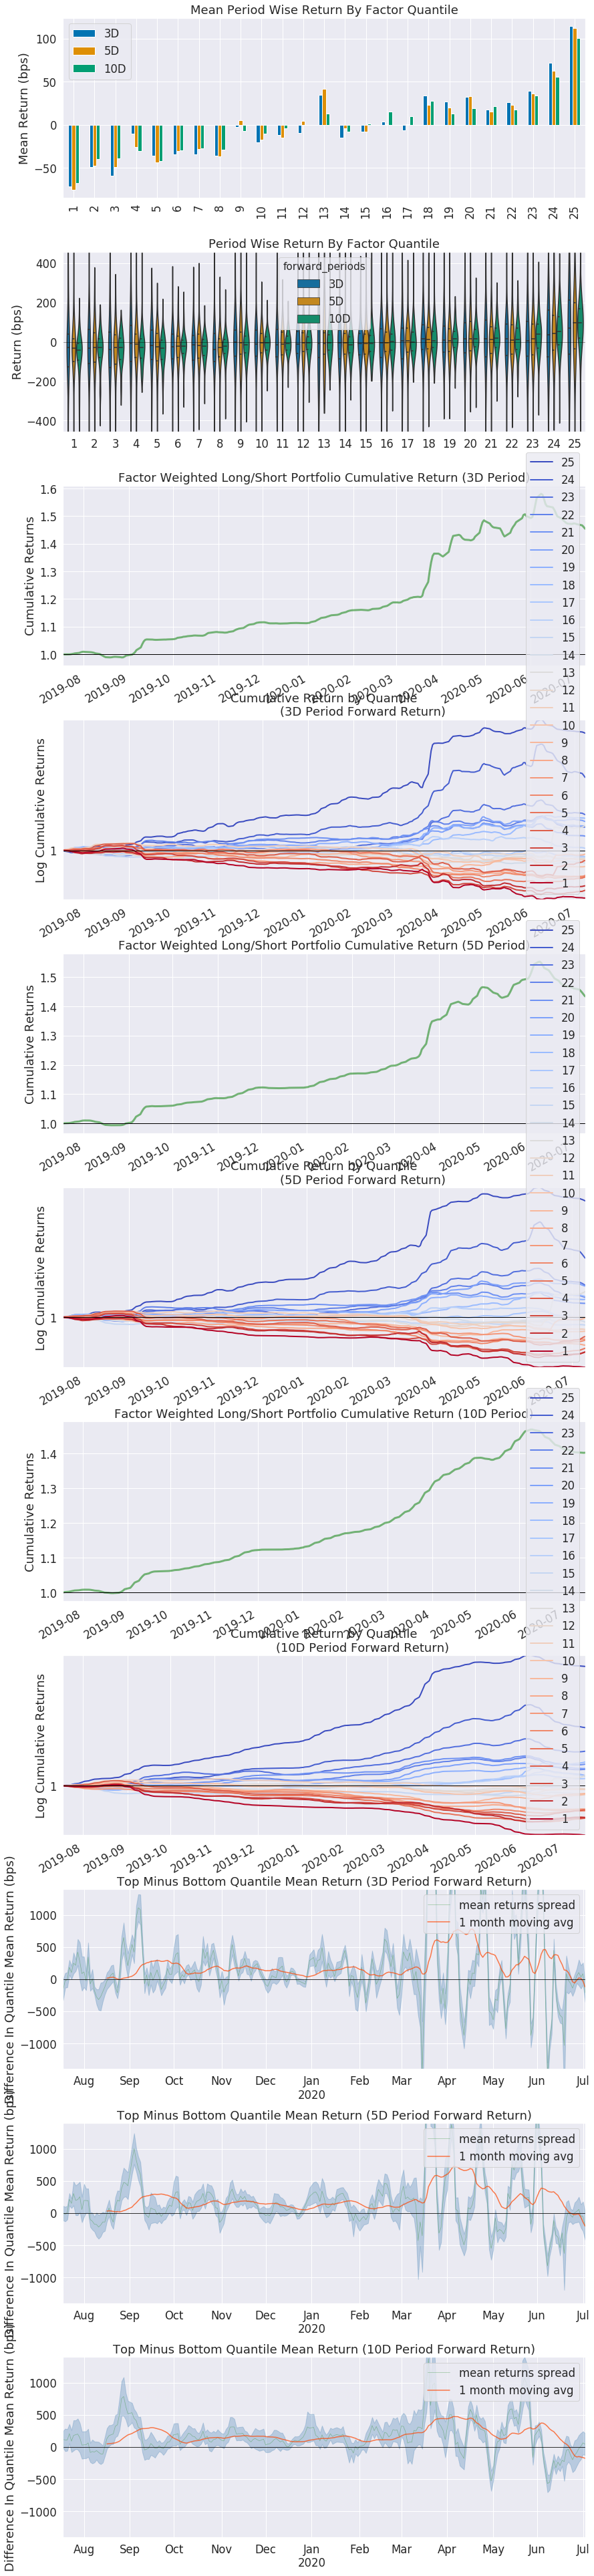

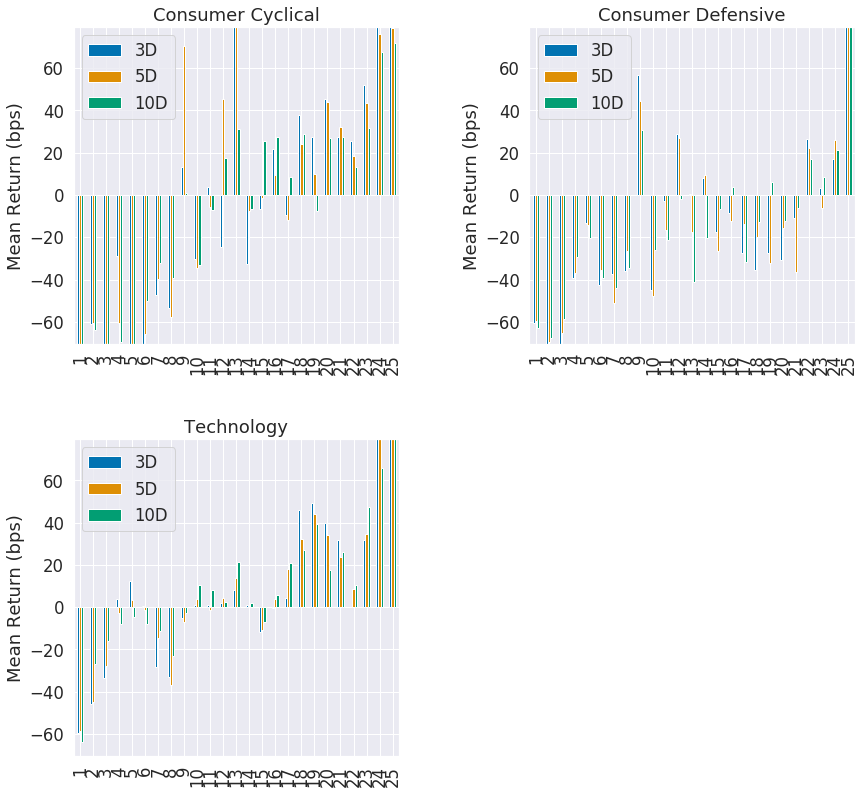

Information Analysis


3D     5D    10D
IC Mean           0.049  0.067  0.110
IC Std.           0.205  0.216  0.220
Risk-Adjusted IC  0.241  0.308  0.500
t-stat(IC)        3.762  4.798  7.797
p-value(IC)       0.000  0.000  0.000
IC Skew           0.018 -0.008 -0.444
IC Kurtosis       0.163 -0.021 -0.027

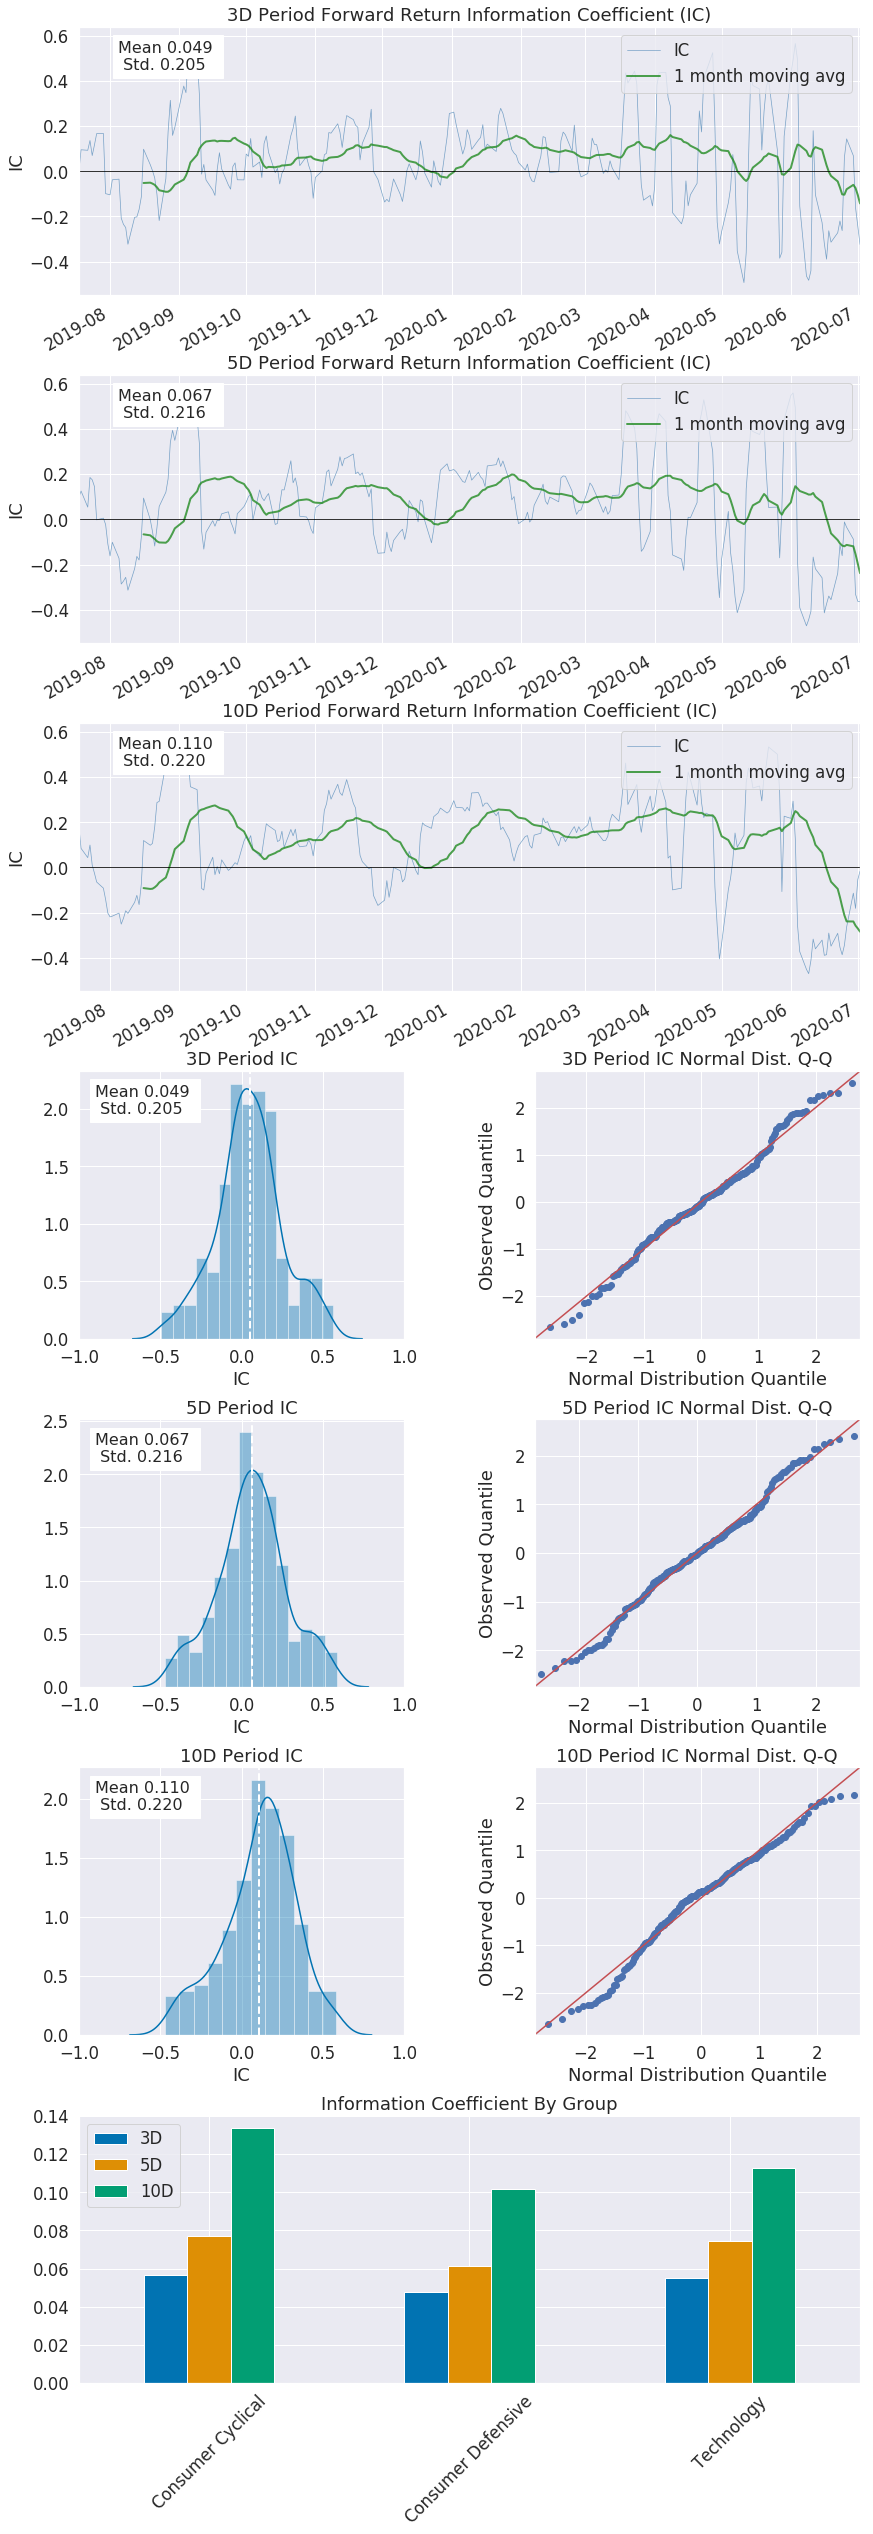

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover    0.429  0.196  0.282
Quantile 2 Mean Turnover    0.742  0.465  0.598
Quantile 3 Mean Turnover    0.809  0.577  0.692
Quantile 4 Mean Turnover    0.831  0.648  0.745
Quantile 5 Mean Turnover    0.870  0.701  0.793
Quantile 6 Mean Turnover    0.873  0.721  0.810
Quantile 7 Mean Turnover    0.887  0.744  0.835
Quantile 8 Mean Turnover    0.882  0.764  0.837
Quantile 9 Mean Turnover    0.902  0.776  0.844
Quantile 10 Mean Turnover   0.904  0.768  0.852
Quantile 11 Mean Turnover   0.900  0.757  0.847
Quantile 12 Mean Turnover   0.905  0.783  0.852
Quantile 13 Mean Turnover   0.911  0.772  0.847
Quantile 14 Mean Turnover   0.919  0.780  0.849
Quantile 15 Mean Turnover   0.906  0.778  0.850
Quantile 16 Mean Turnover   0.894  0.773  0.850
Quantile 17 Mean Turnover   0.899  0.766  0.843
Quantile 18 Mean Turnover   0.890  0.746  0.825
Quantile 19 Mean Turnover   0.888  0.729  0.813
Quantile 20 Mean Turnover   0.865  0.704  0.793
Quantile 21 Mean Turnover   0.876  0.677  0.790
Quantile 22 Mean Turnover   0.835  0.629  0.741
Quantile 23 Mean Turnover   0.812  0.581  0.708
Quantile 24 Mean Turnover   0.754  0.484  0.626
Quantile 25 Mean Turnover   0.470  0.218  0.315

3D     5D    10D
Mean Factor Rank Autocorrelation  0.967  0.932  0.847

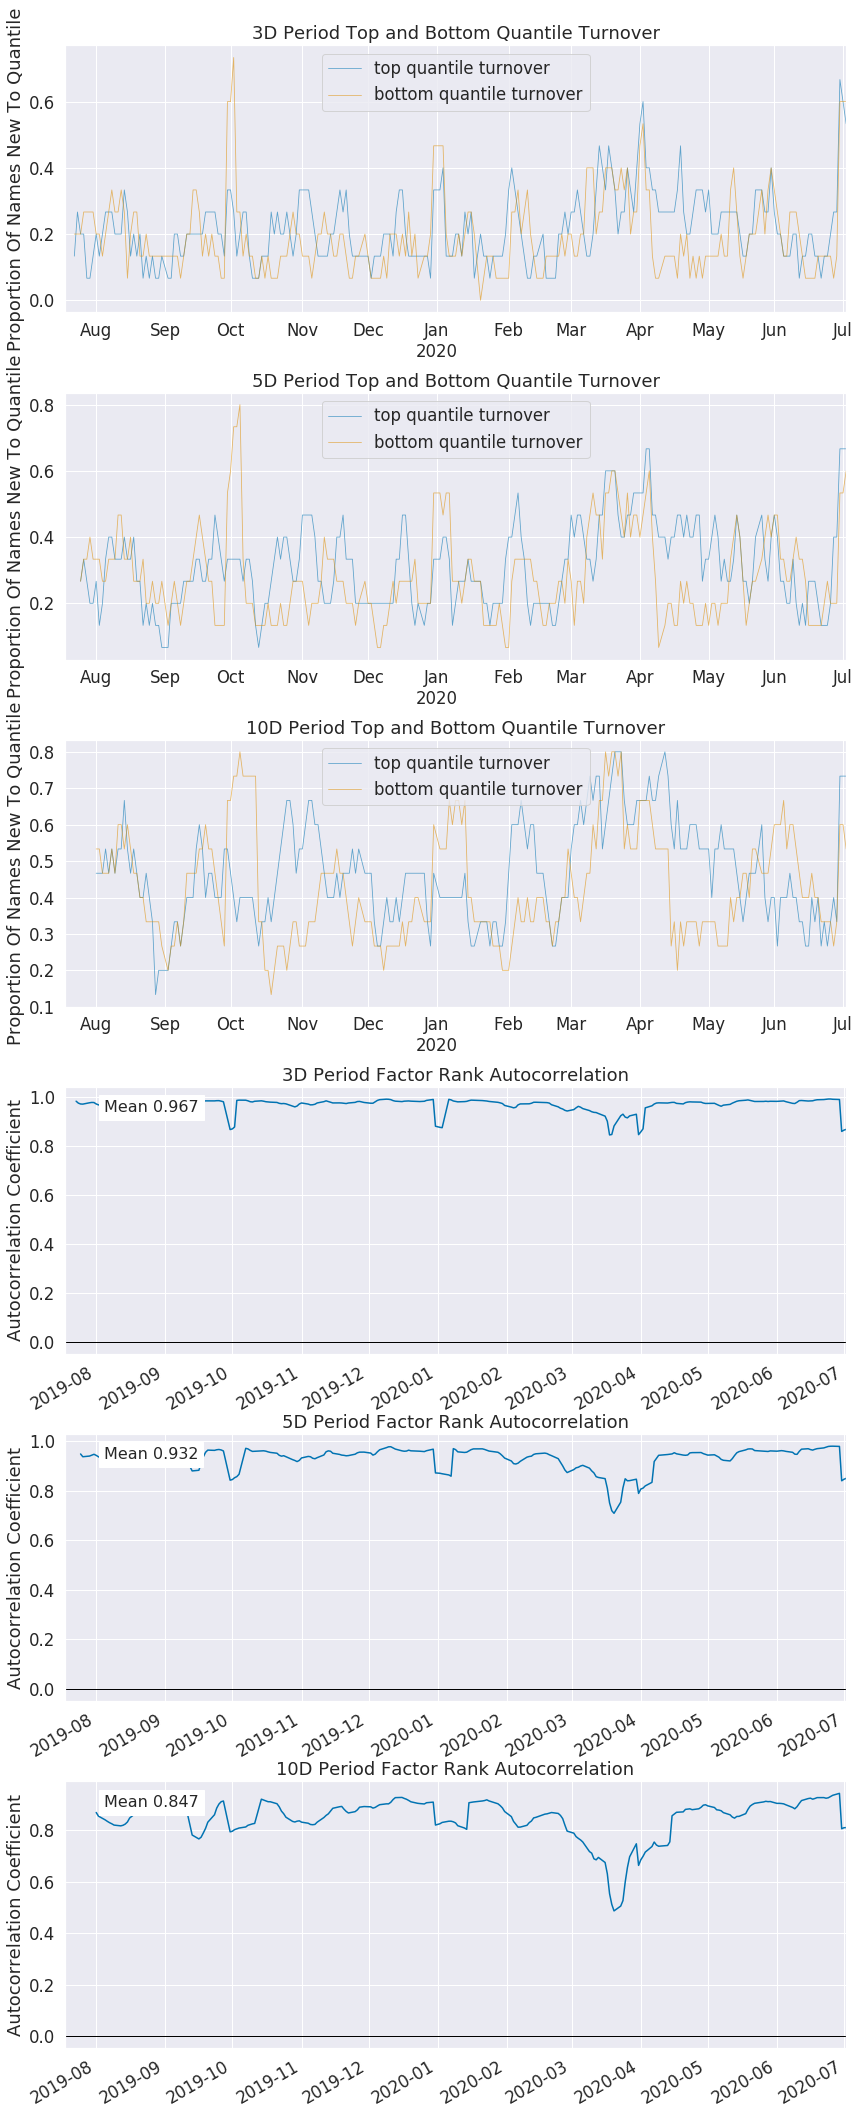

In [85]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

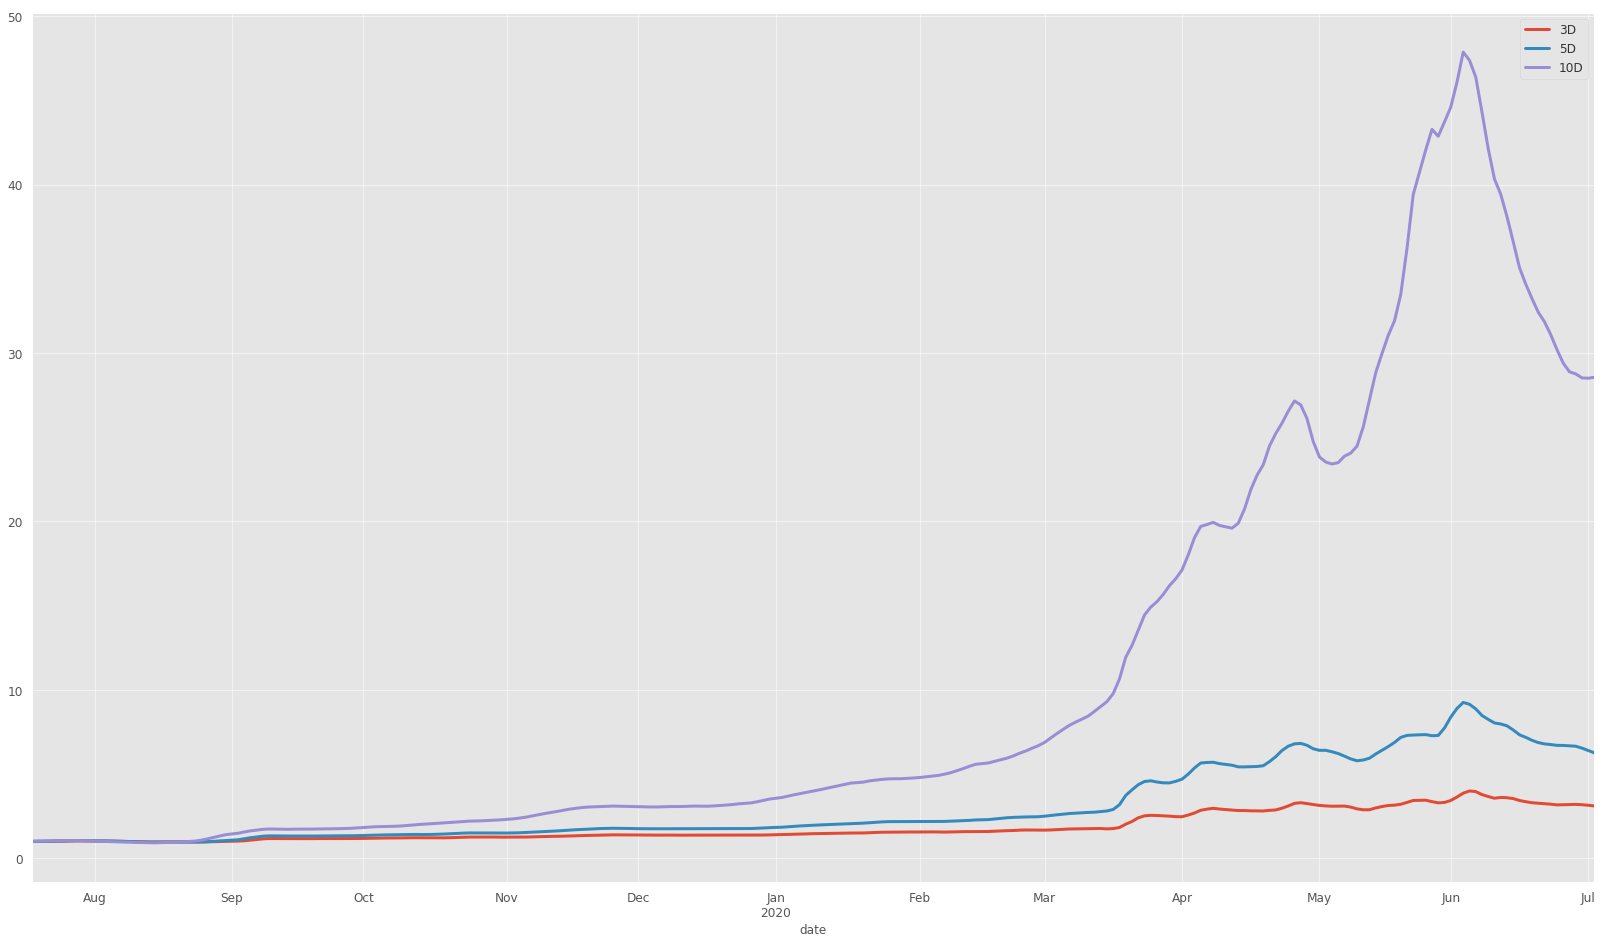

In [86]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data)

(1+ls_factor_returns).cumprod().plot(lw=3);

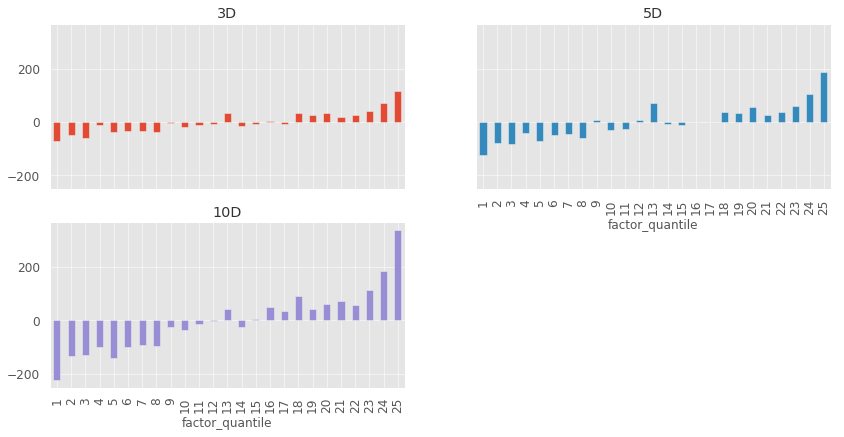

In [87]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

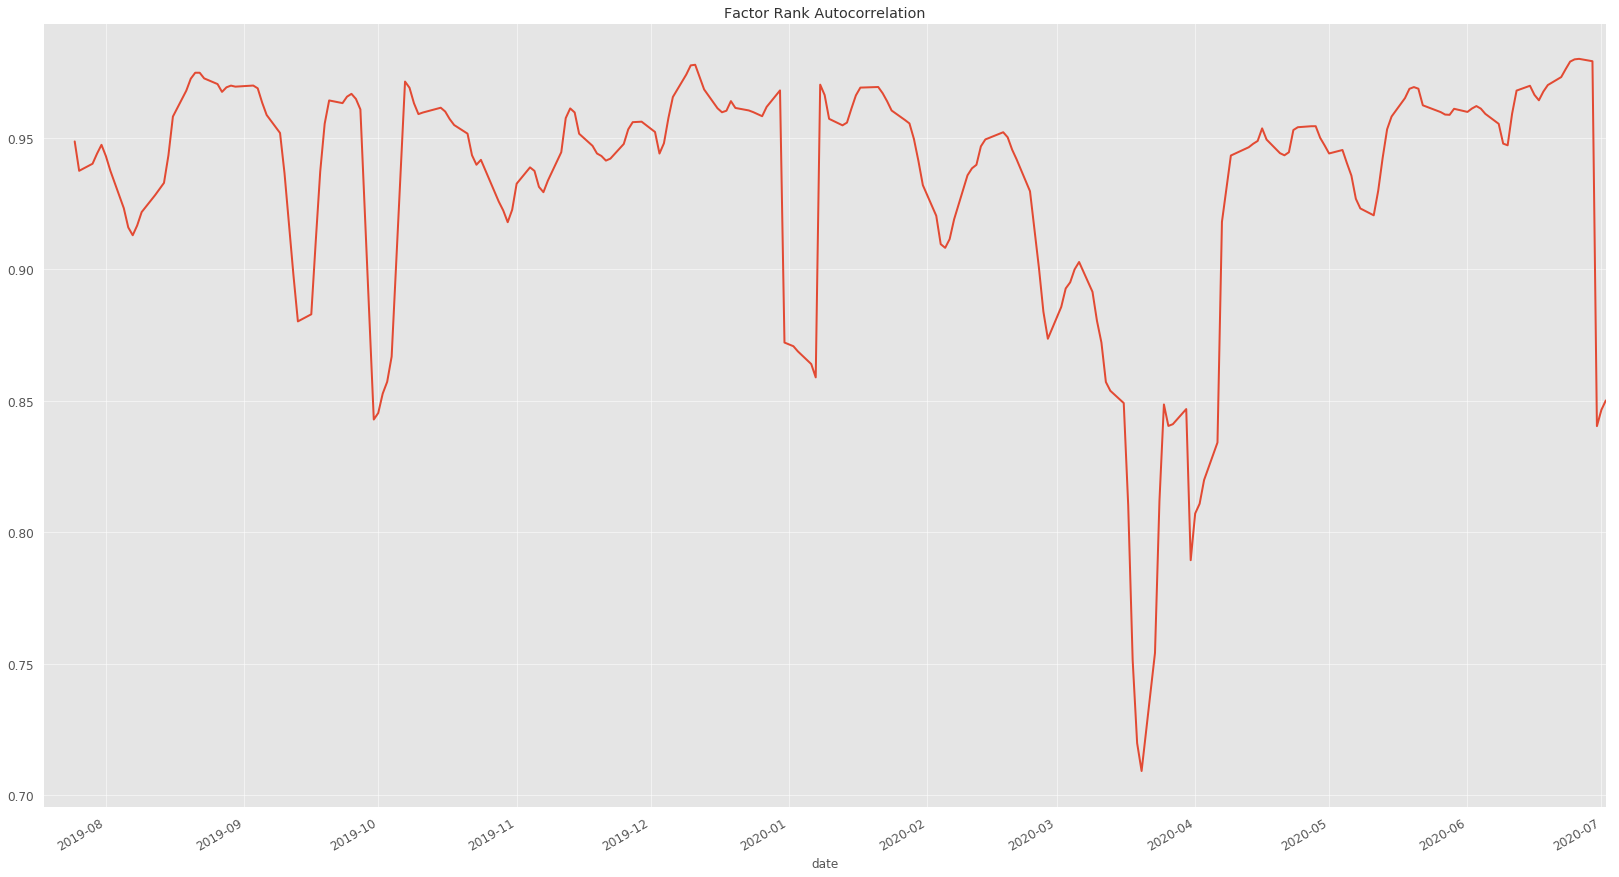

In [88]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [89]:
ls_FRA.mean()

0.9316835783969949

In [90]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

3D     4.29
5D     5.43
10D    9.14
dtype: float64

# 7 -  Risk analysis for equal weights

In [91]:
assets = all_factors.index.levels[1]

In [92]:
all_weights = pd.DataFrame(np.repeat(1/len(assets), len(assets)), assets)

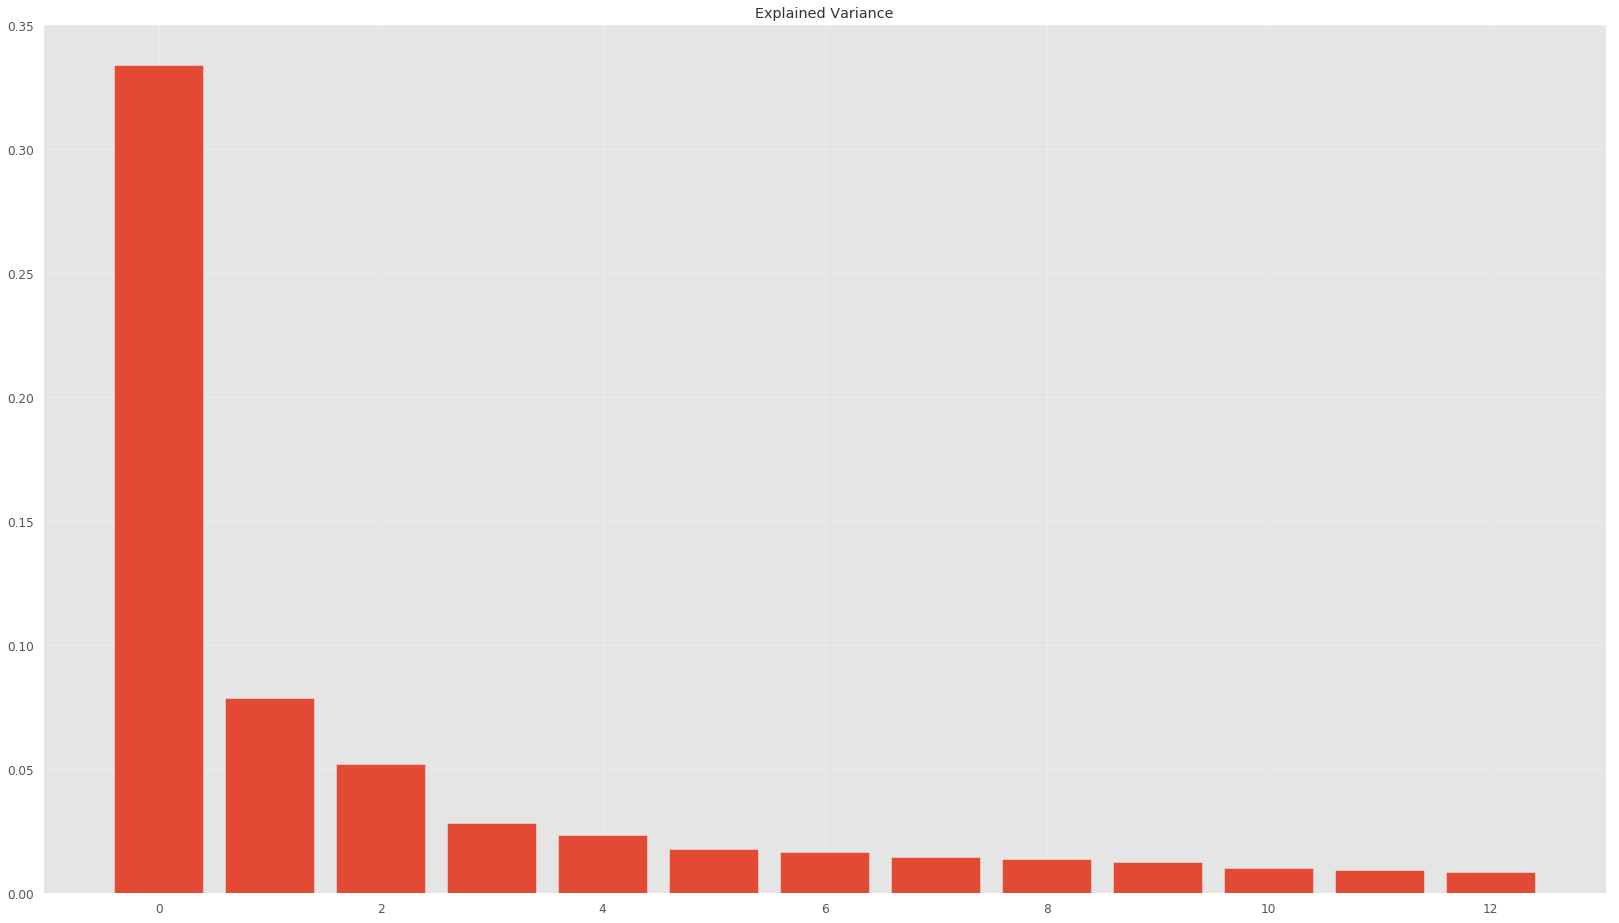

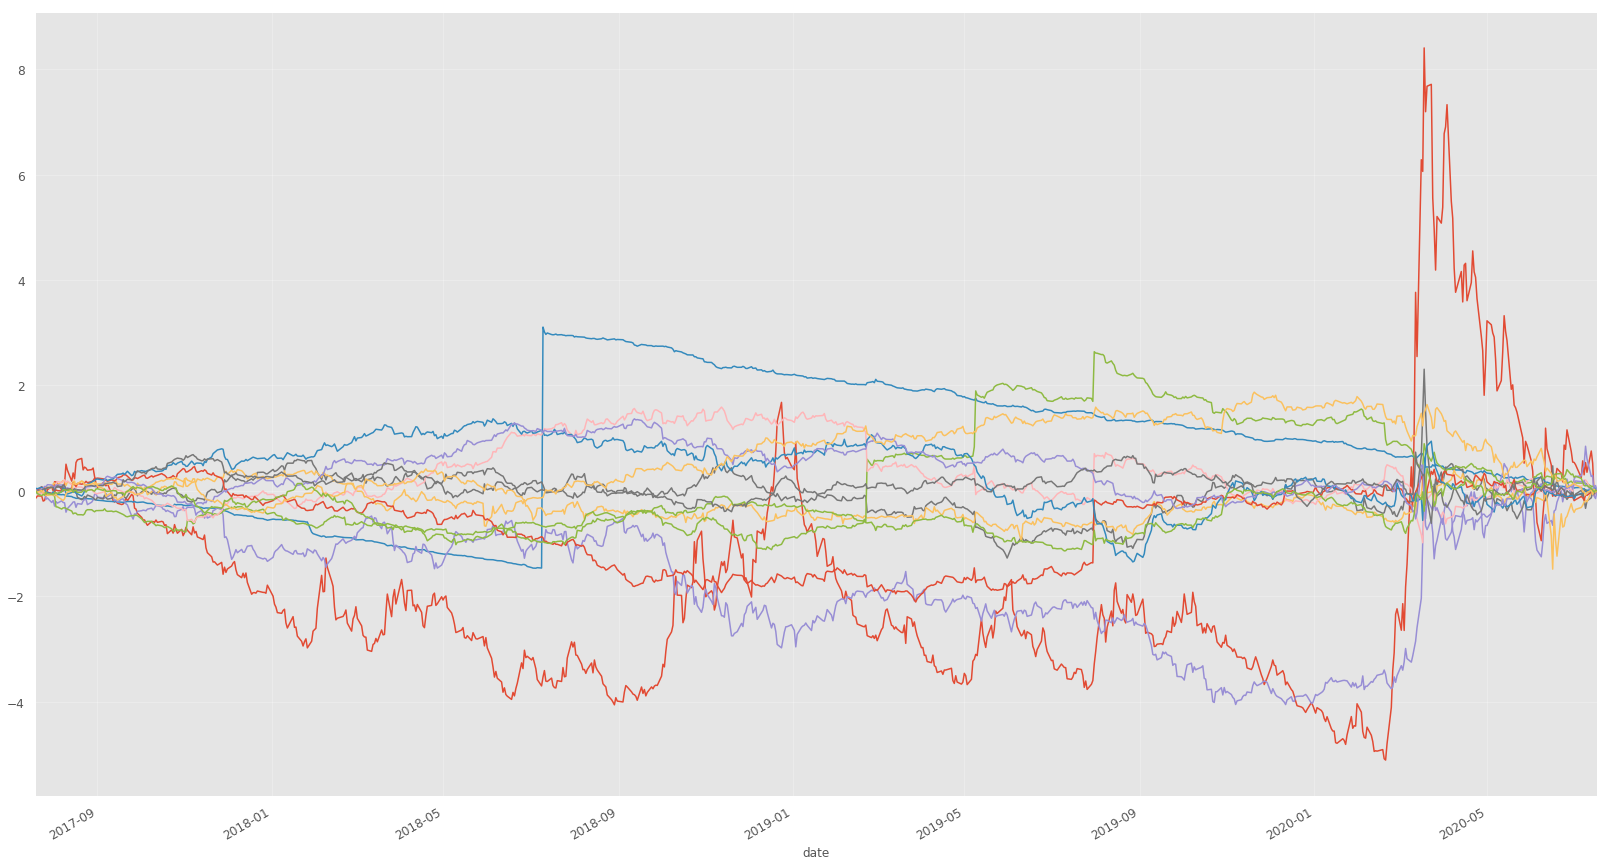

In [93]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[assets],num_factor_exposures=13,weights=all_weights)

In [94]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 26.71 %


# 8 - Integrating factor data to optimzer

In [95]:
optimal = pd.DataFrame(index = all_factors.index.levels[0], columns = all_factors.index.levels[1])
for date in all_factors.index.levels[0]:
    
    x = all_factors[['alpha_vector']].loc[date.date(),:]
    optimal.loc[date] = risk_model\
                          .OptimalHoldingsRegularization(lambda_reg = lambda_reg,
                                                         risk_cap = risk_cap).find(
                                                            x, 
                                                            Risk_Model['factor_betas'], 
                                                            Risk_Model['factor_cov_matrix'], 
                                                            Risk_Model['idiosyncratic_var_vector']).values.flatten()
    

    
optimal = optimal.astype(np.float)
optimal_stacked = optimal.stack().to_frame('optimal_weights')

In [96]:
assert optimal_stacked.shape[0] == vec.shape[0]

## Quantilize data

In [97]:
quantile_optimal_stacked = pd.DataFrame(index = optimal_stacked.index, 
                                        columns = ['optimal_weights','quantile','sector'])
qunatiles = np.linspace(0,1,qunatile_portions+1)
labels = [i+1 for i in range(len(qunatiles)-1)]

for date in optimal_stacked.index.levels[0]:
    
    x = optimal_stacked['optimal_weights'].loc[date.date(),:]
    
    quantile_optimal_stacked.loc[date,'quantile'] = pd.qcut(x, qunatiles, 
                                                            labels = labels)
    
quantile_optimal_stacked.loc[:,'optimal_weights'] = optimal_stacked['optimal_weights']
quantile_optimal_stacked.loc[:,'sector'] = vec['sector']

In [98]:
quantile_optimal_stacked.shape

(94369, 3)

In [99]:
try:
    q_list = []
    for i in quantile_to_analyse:
        q_list.append((quantile_optimal_stacked['quantile'] == i))

    df_merge = q_list[0]
    for df in q_list[1:]:       
        df_merge = df_merge ^ df
    
    q_final_vector = quantile_optimal_stacked[df_merge]
    
except:
    
    print ('no specific quantile selected')
    q_final_vector = quantile_optimal_stacked

In [100]:
remaining_quantiles = list(set(q_final_vector.loc[:,'quantile'].values))

In [101]:
rows = q_final_vector.shape[0]

## Sector Selection

In [102]:
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[-1]))

    for i in drop_short_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[0]))

    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    final_vector = q_final_vector[~df_merge]
    sectors = final_vector['sector']
    
    assert list(final_vector[(final_vector['quantile'] == labels[-1]) & (final_vector['sector'] == drop_long_sec[0])].values) == []
    assert list(final_vector[(final_vector['quantile'] == labels[0]) & (final_vector['sector'] == drop_short_sec[0])].values) == []

except:
    final_vector = q_final_vector
    sectors = final_vector['sector']

In [103]:
print ('{} rows dropped from final vector'.format(rows - final_vector.shape[0]))

0 rows dropped from final vector


## Balancing to long/short leverage target

In [104]:
for date in final_vector.index.levels[0]:
    
    long_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0].sum())
    short_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0].sum())
    
    long_ratio = percent_long_leverage_target / long_balance
    short_ratio = percent_short_leverage_target / short_balance

    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] * long_ratio
    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] * short_ratio

## 9 - 1 - Creating clean factor data

In [105]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = final_vector['optimal_weights'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = len(remaining_quantiles),
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


In [106]:
rows = factor_data.shape[0]

In [107]:
# Sector Selection
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 2))

    for i in drop_short_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 1))
    
    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    factor_data = factor_data[~df_merge]
    sectors = factor_data['group']
    
except:
    
    sectors = factor_data['group']

In [108]:
print ('{} rows dropped from factor data'.format(rows - factor_data.shape[0]))

0 rows dropped from factor data


## 8 - 3 - Creating tear sheets 

In [109]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                   period= '{}D'.format(rebalance_period),
                                   capital=1,
                                   long_short=True,
                                   group_neutral=False,
                                   equal_weight=False,
                                   groups=sectors,
                                   #quantiles=[1,5],
                                   benchmark_period='{}D'.format(rebalance_period))

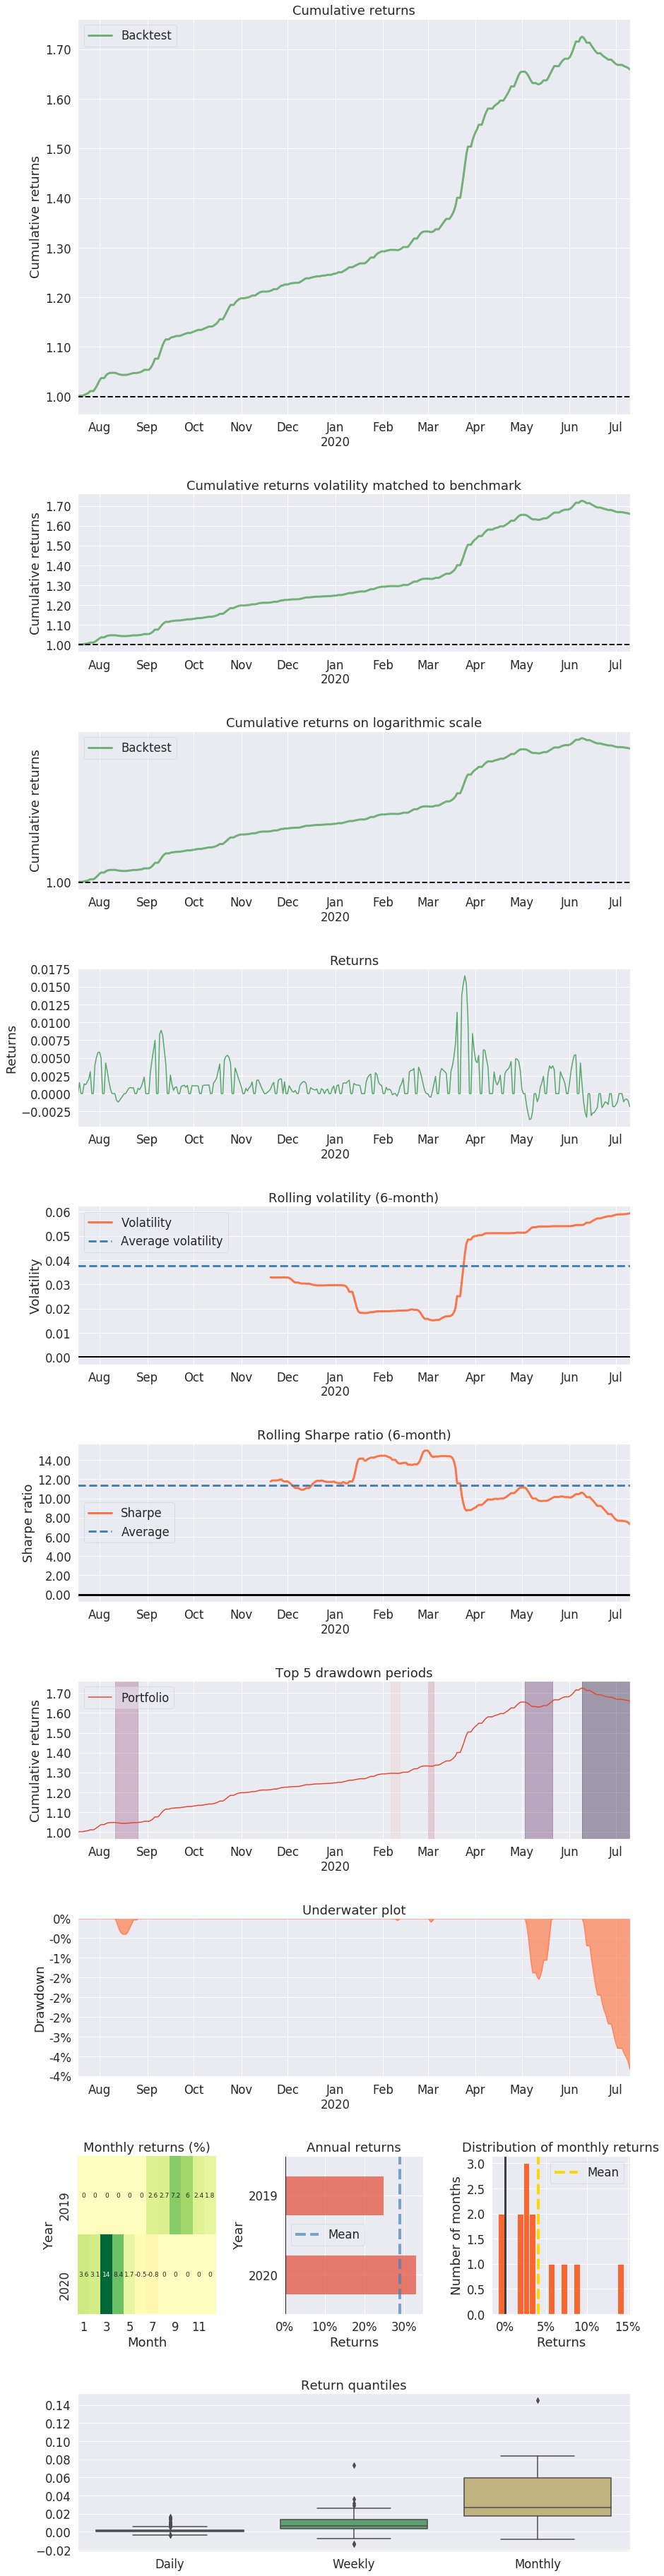

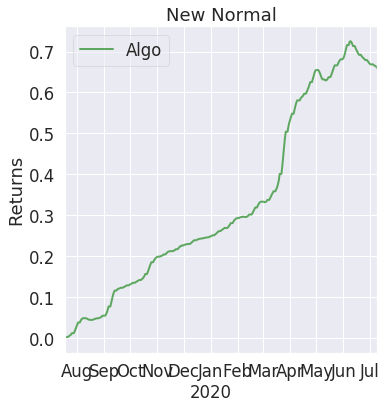

In [110]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min           max      mean       std  count  count %
factor_quantile                                                            
1               -0.159246 -5.284919e-08 -0.026667  0.022886   3645     50.0
2                0.005776  2.882630e-01  0.040000  0.032595   3645     50.0

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.634    0.640    0.579
beta                                             0.125    0.120    0.063
Mean Period Wise Return Top Quantile (bps)      63.494   64.378   55.069
Mean Period Wise Return Bottom Quantile (bps)  -63.494  -64.656  -55.786
Mean Period Wise Spread (bps)                  126.989  129.088  110.929

<Figure size 2016x1152 with 0 Axes>

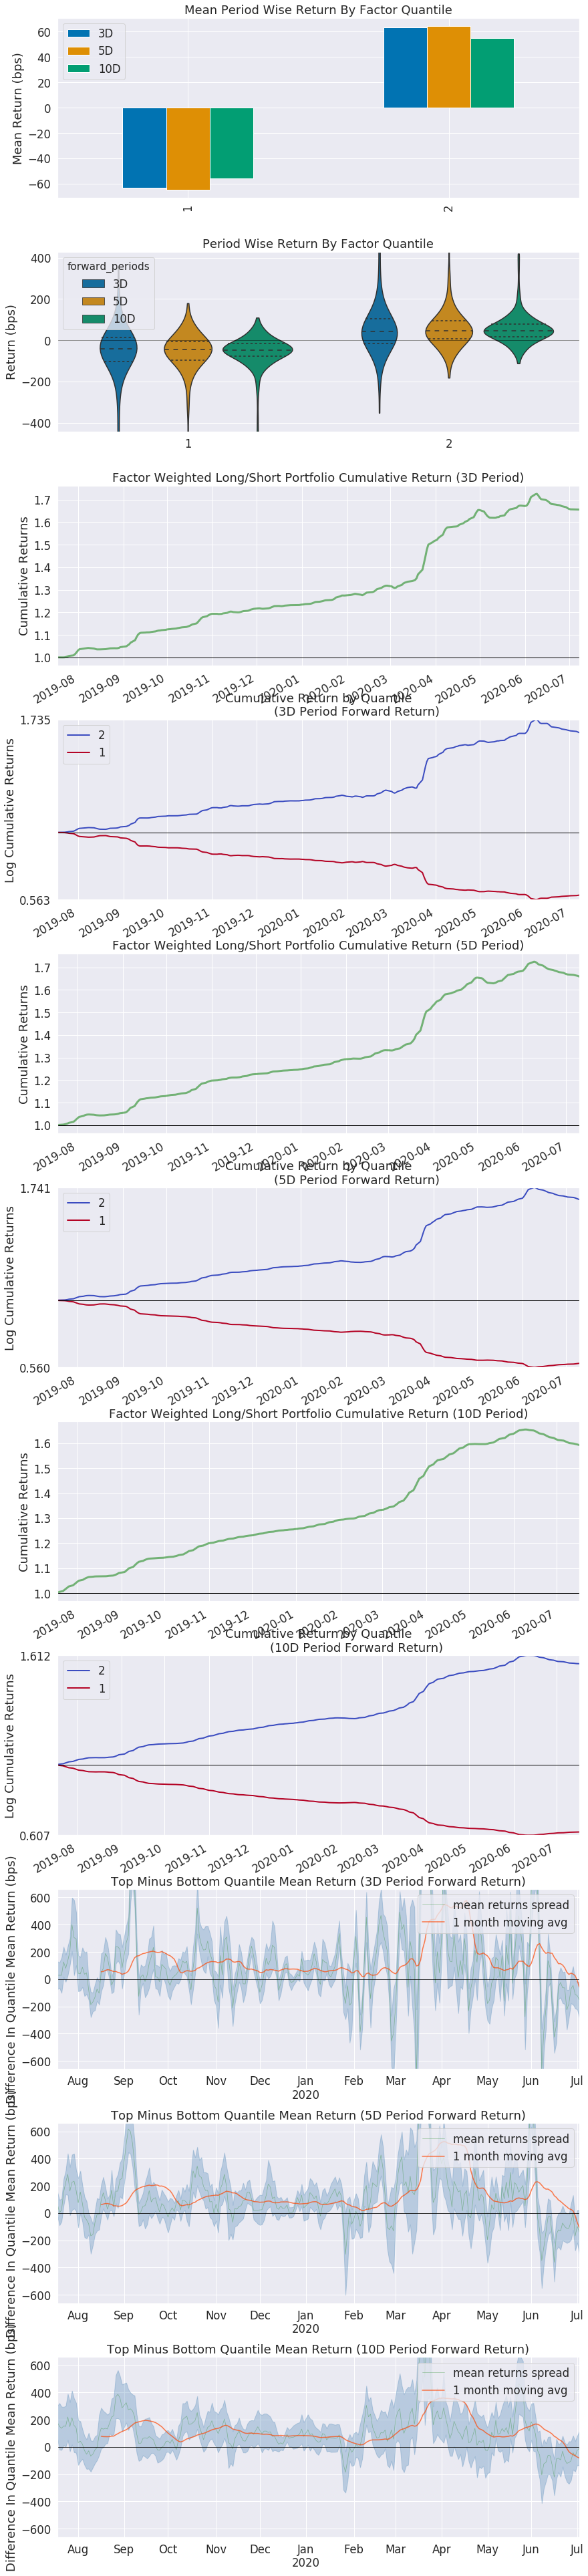

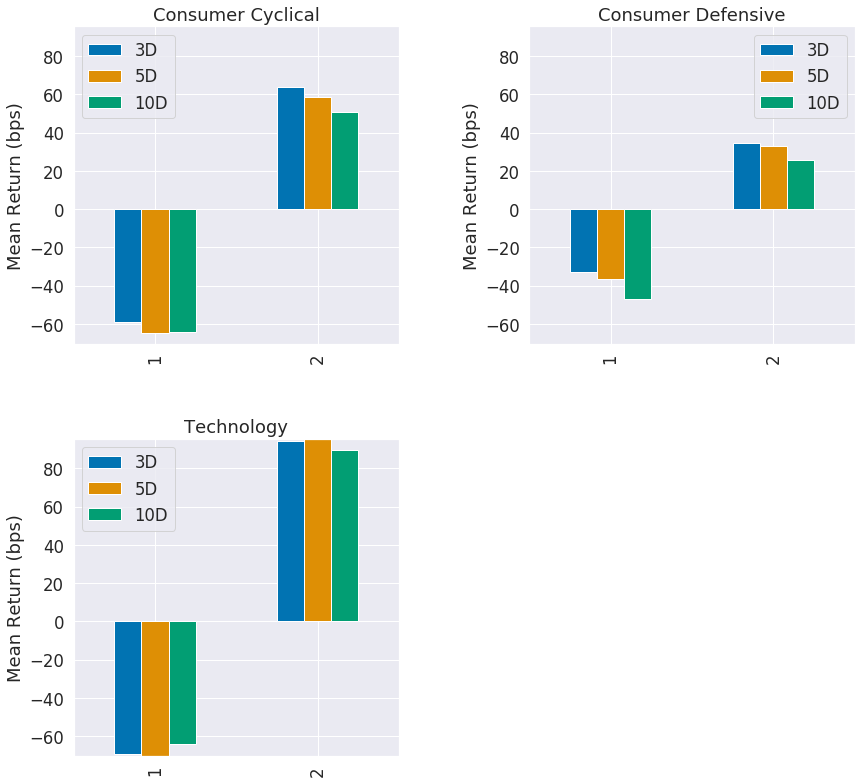

Information Analysis


3D      5D     10D
IC Mean           0.105   0.152   0.220
IC Std.           0.235   0.236   0.260
Risk-Adjusted IC  0.448   0.646   0.846
t-stat(IC)        6.991  10.076  13.188
p-value(IC)       0.000   0.000   0.000
IC Skew          -0.033  -0.152  -0.346
IC Kurtosis       0.259  -0.136  -0.294

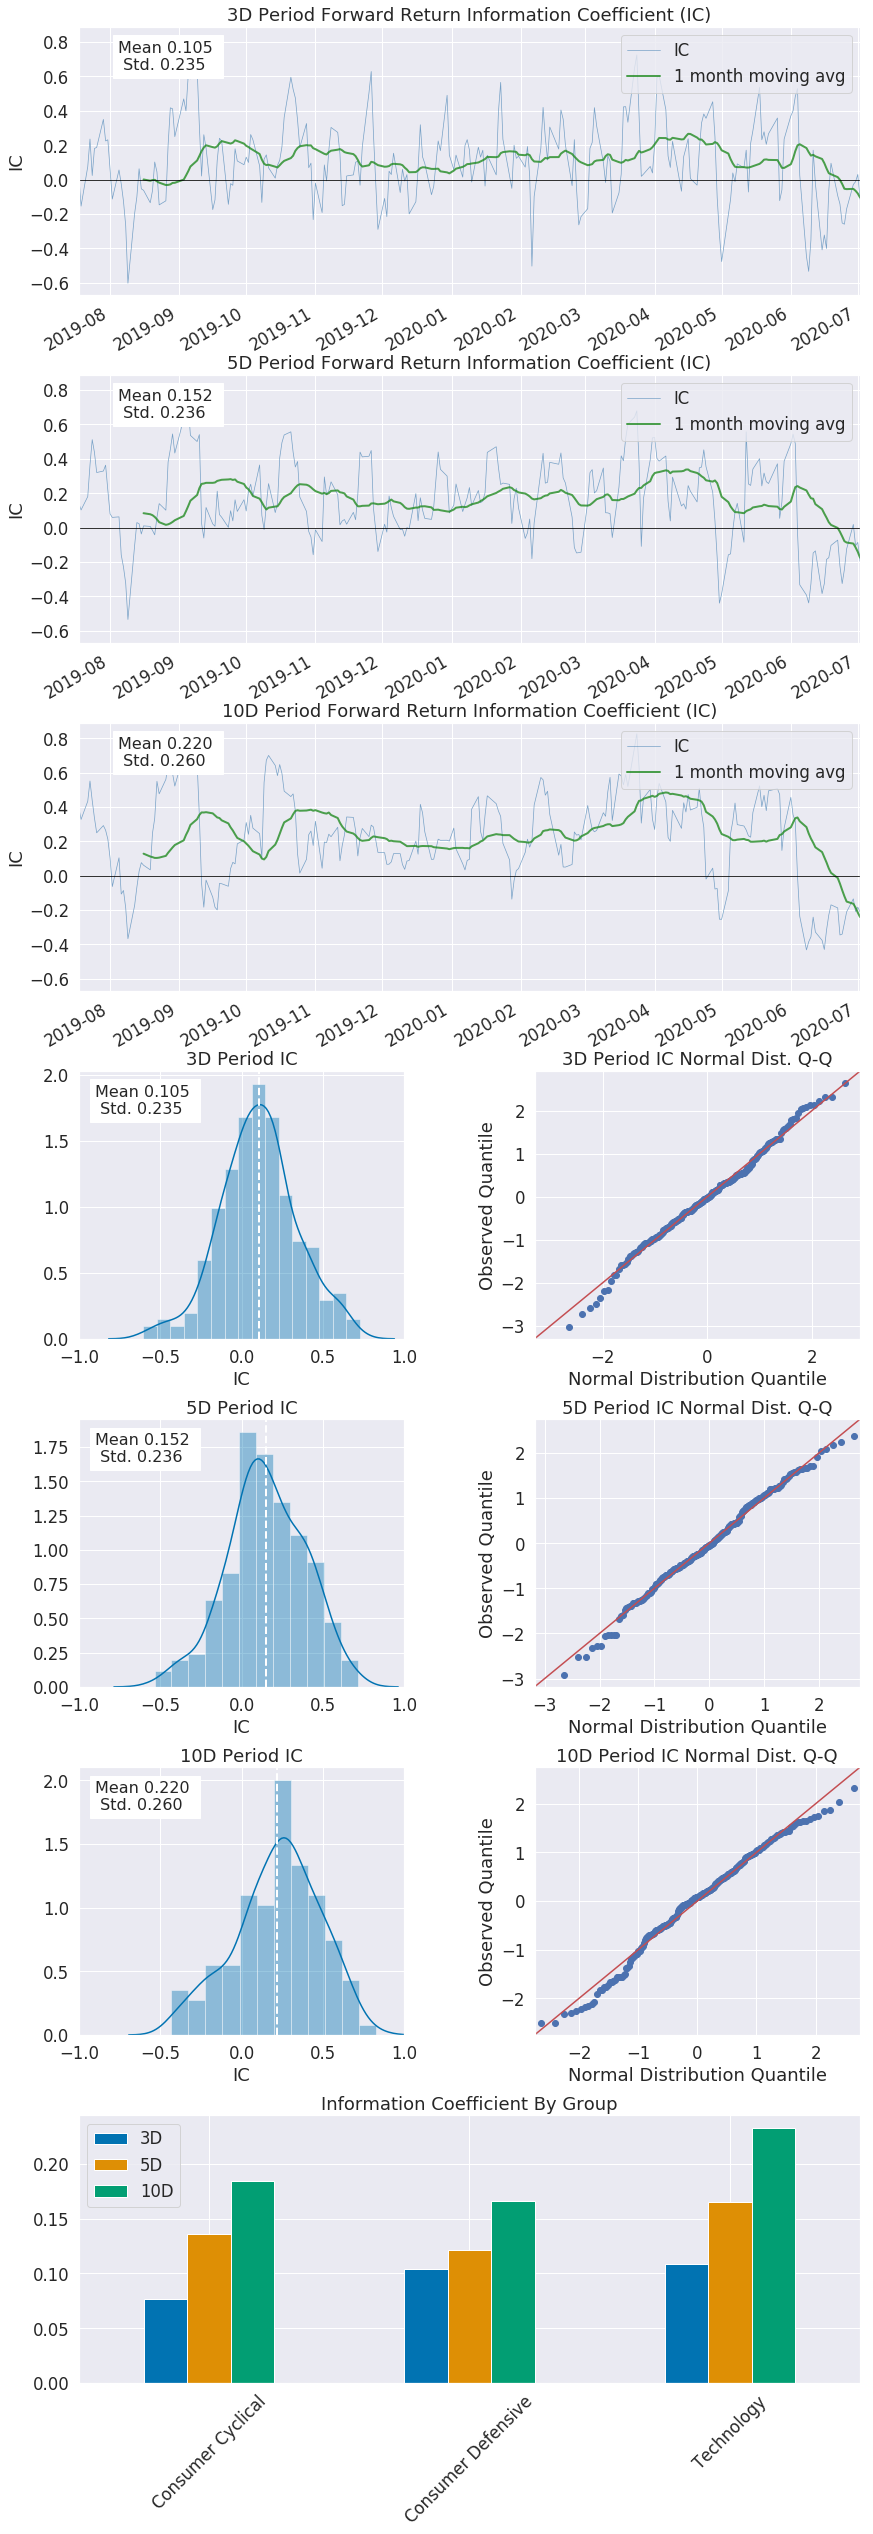

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover   0.474  0.211  0.311
Quantile 2 Mean Turnover   0.454  0.215  0.312

3D     5D    10D
Mean Factor Rank Autocorrelation  0.943  0.922  0.901

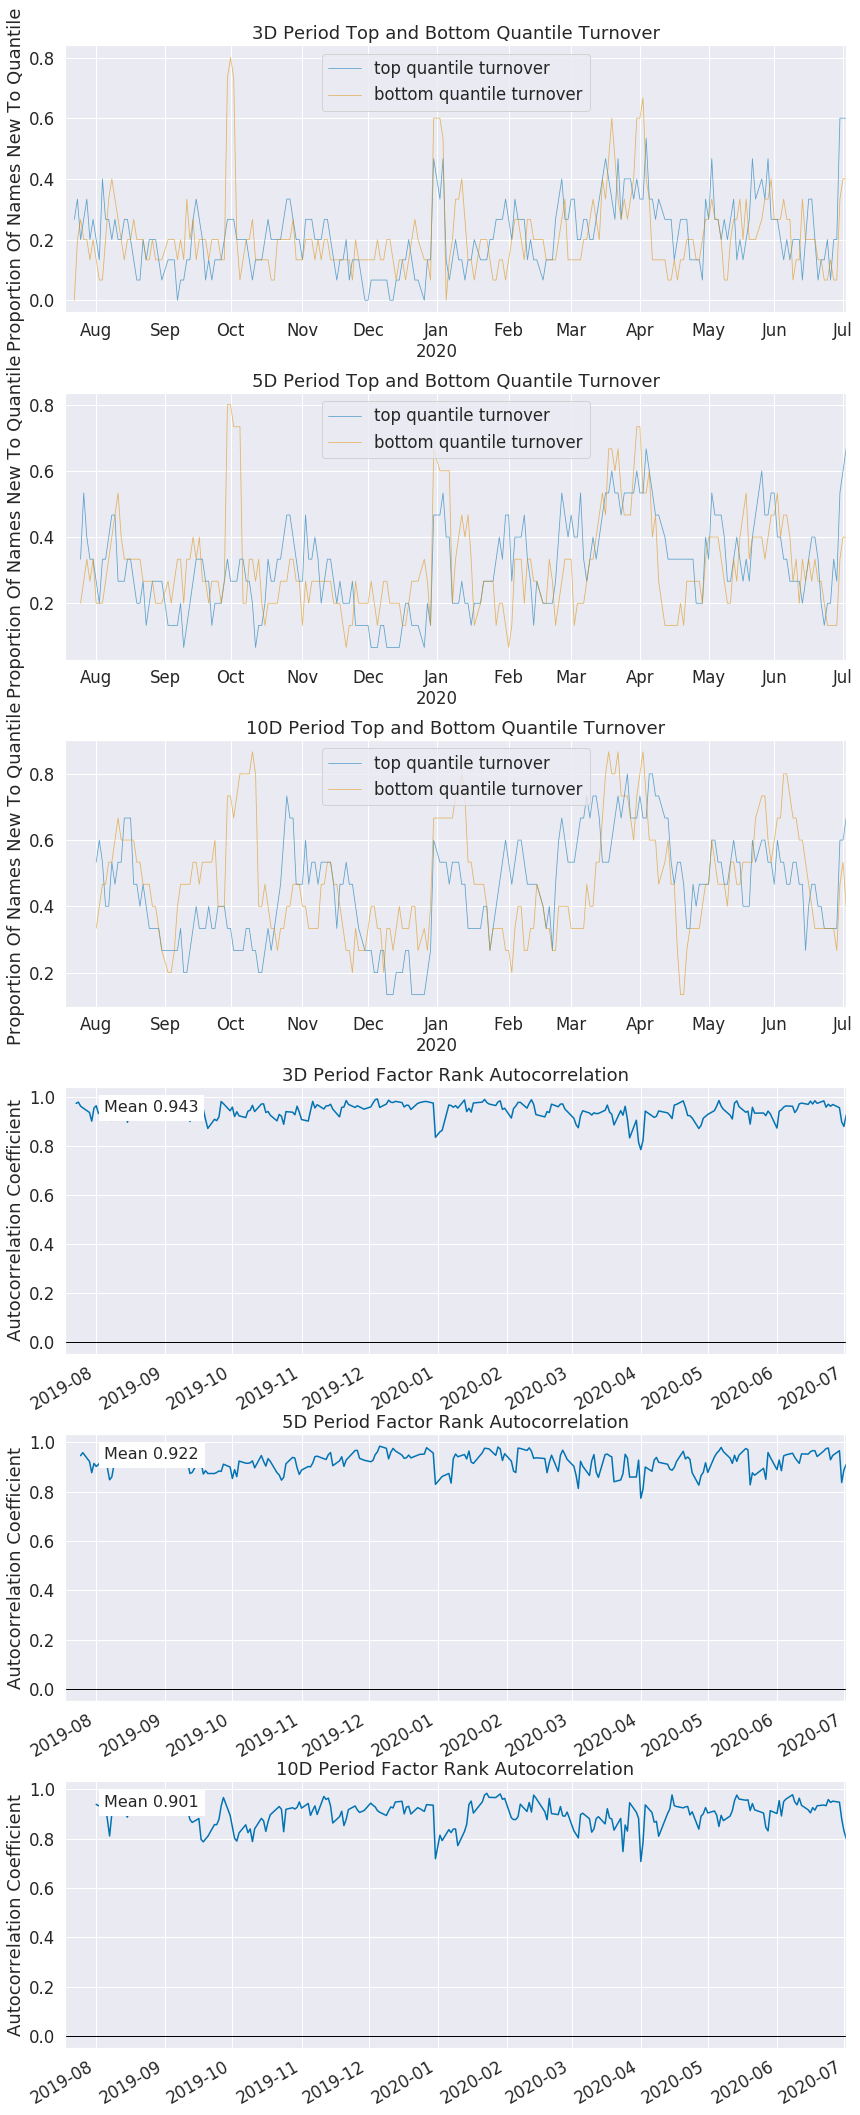

In [111]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

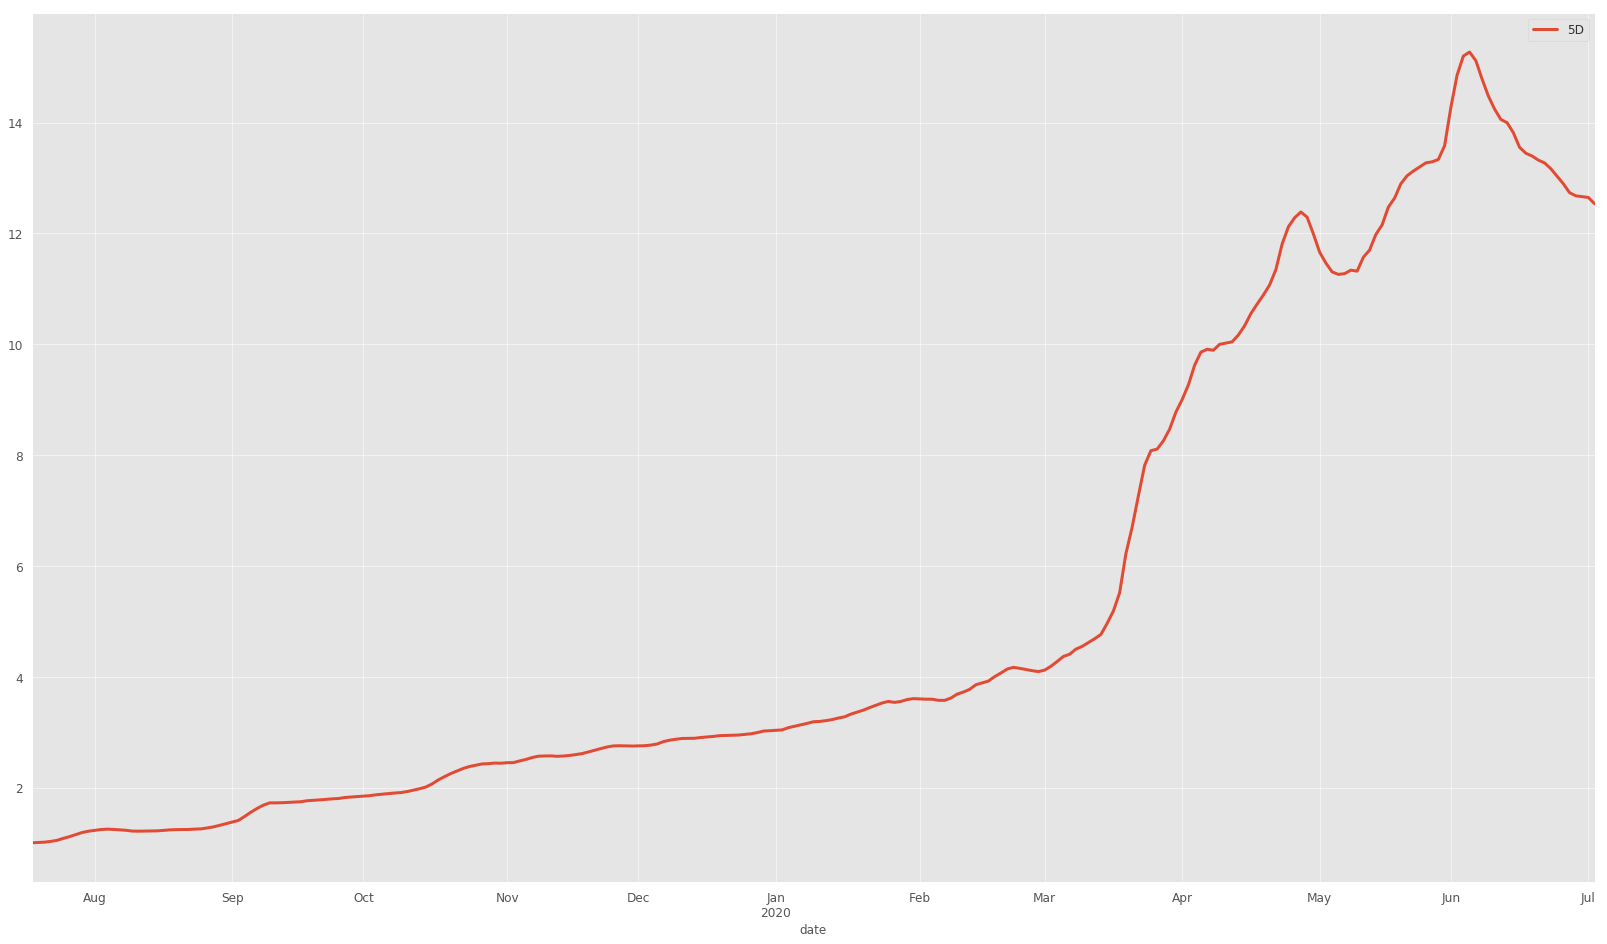

In [112]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data[['factor','5D']])

(1+ls_factor_returns).cumprod().plot(lw=3);

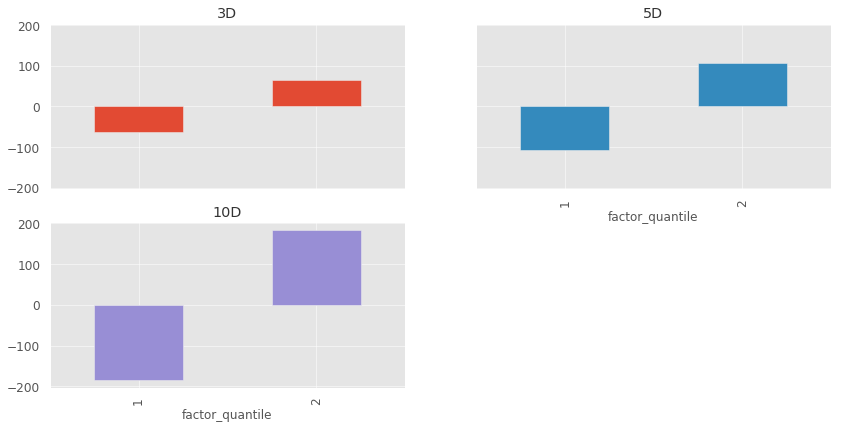

In [113]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

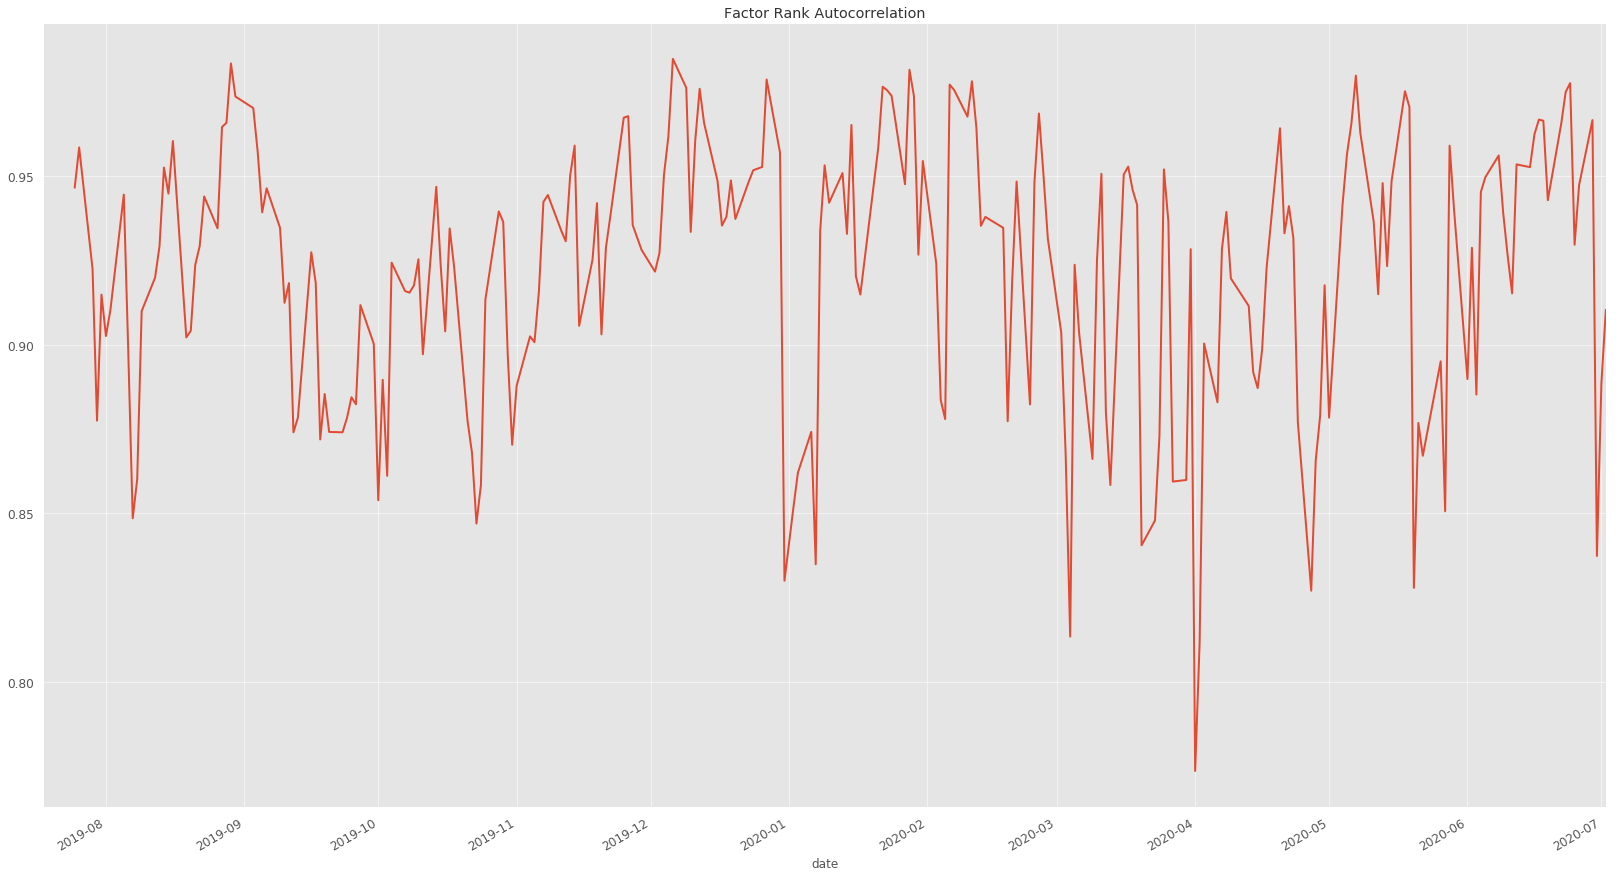

In [114]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [115]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

5D    9.64
dtype: float64

# 10 - Predicted Portfolio

In [116]:
optimal_weights_regularized = final_vector[['optimal_weights']].loc[final_vector.index.levels[0][-1]]

for 30 assets  with end date: 2020-07-17 00:00:00+00:00


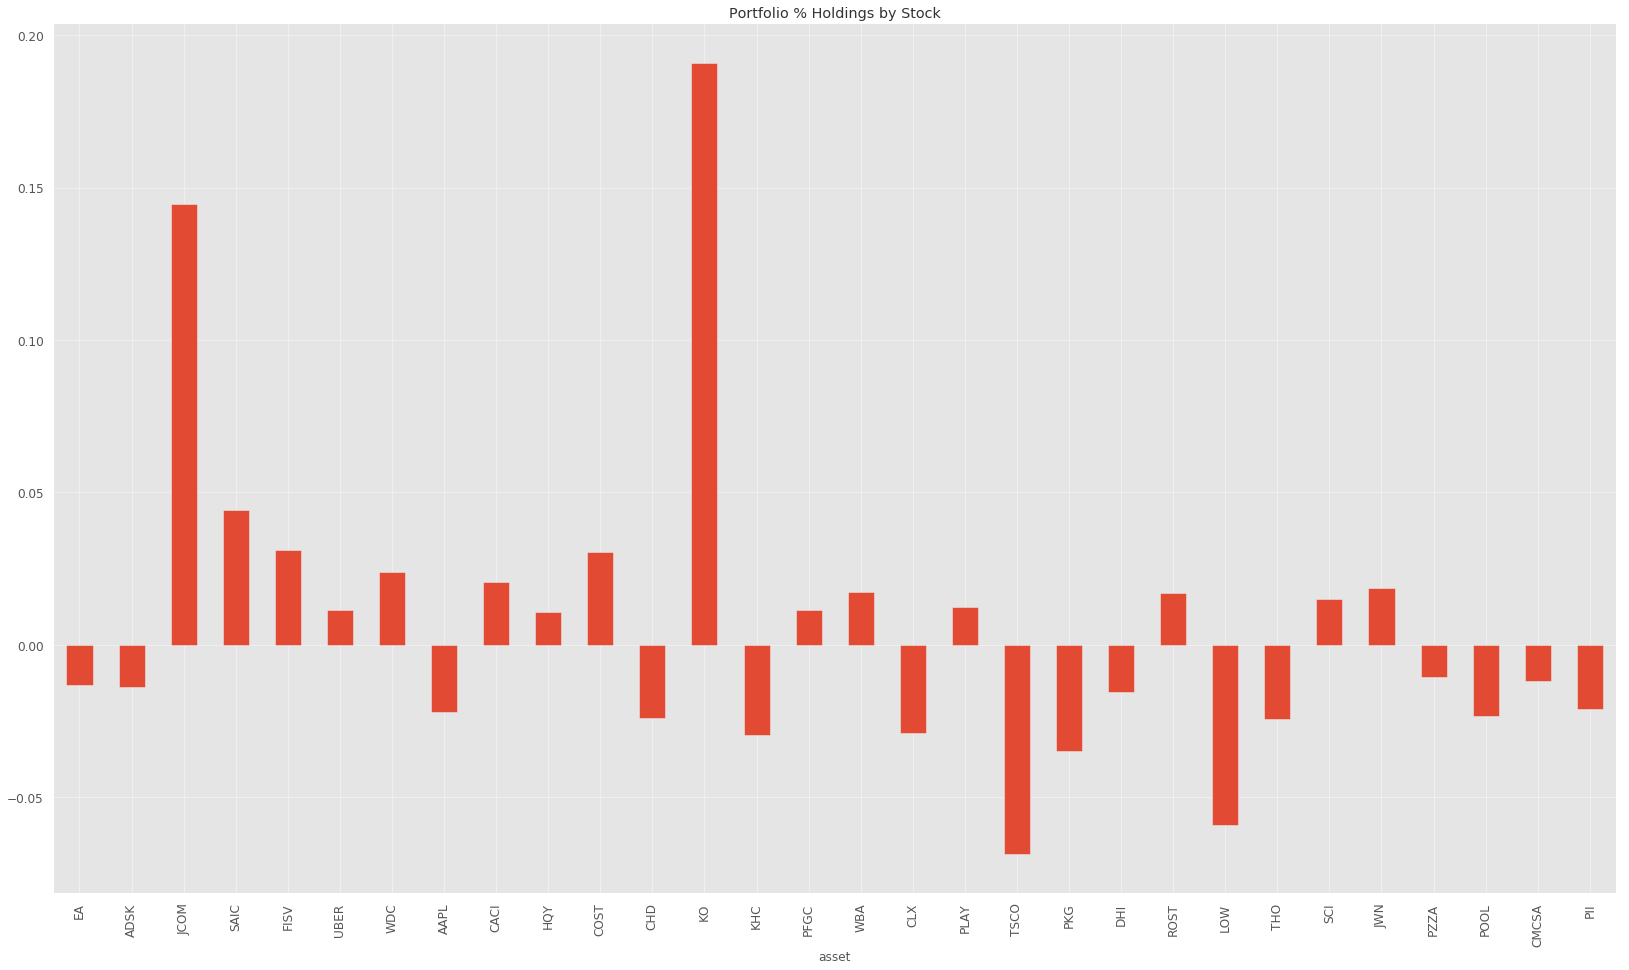

In [117]:
print ('for {} assets  with end date: {}'.format(len(optimal_weights_regularized.index),optimal.index[-1]))
optimal_weights_regularized.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.grid(alpha=0.8)

In [118]:
optimal_weights_regularized = pd.DataFrame(data = optimal_weights_regularized.values, 
                                           columns = ['optimal_weights'],
                                           index = optimal_weights_regularized.index)
optimal_weights_regularized.index.name = 'asset'

In [119]:
q5 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=False)[:len(optimal_weights_regularized.index)//5]
q1 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=True)[:len(optimal_weights_regularized.index)//5]

In [120]:
print (q5.iloc[0])
print (q1.iloc[0])

optimal_weights    0.190848
Name: KO, dtype: float64
optimal_weights   -0.068443
Name: TSCO, dtype: float64


## 10 - 3 - Risk analysis with optimized weights

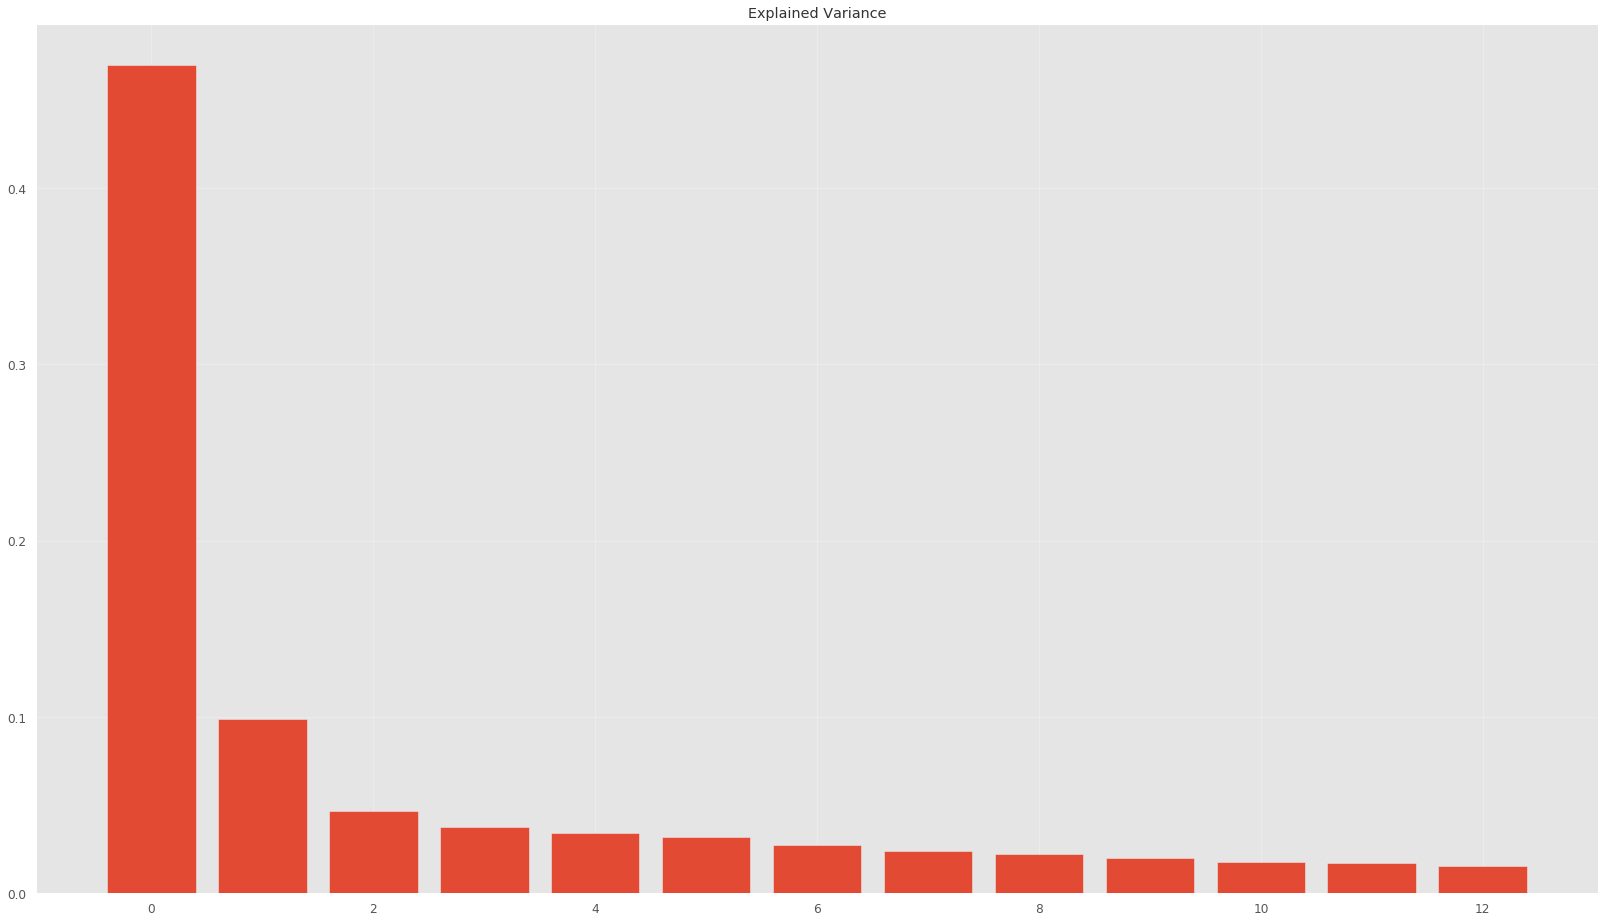

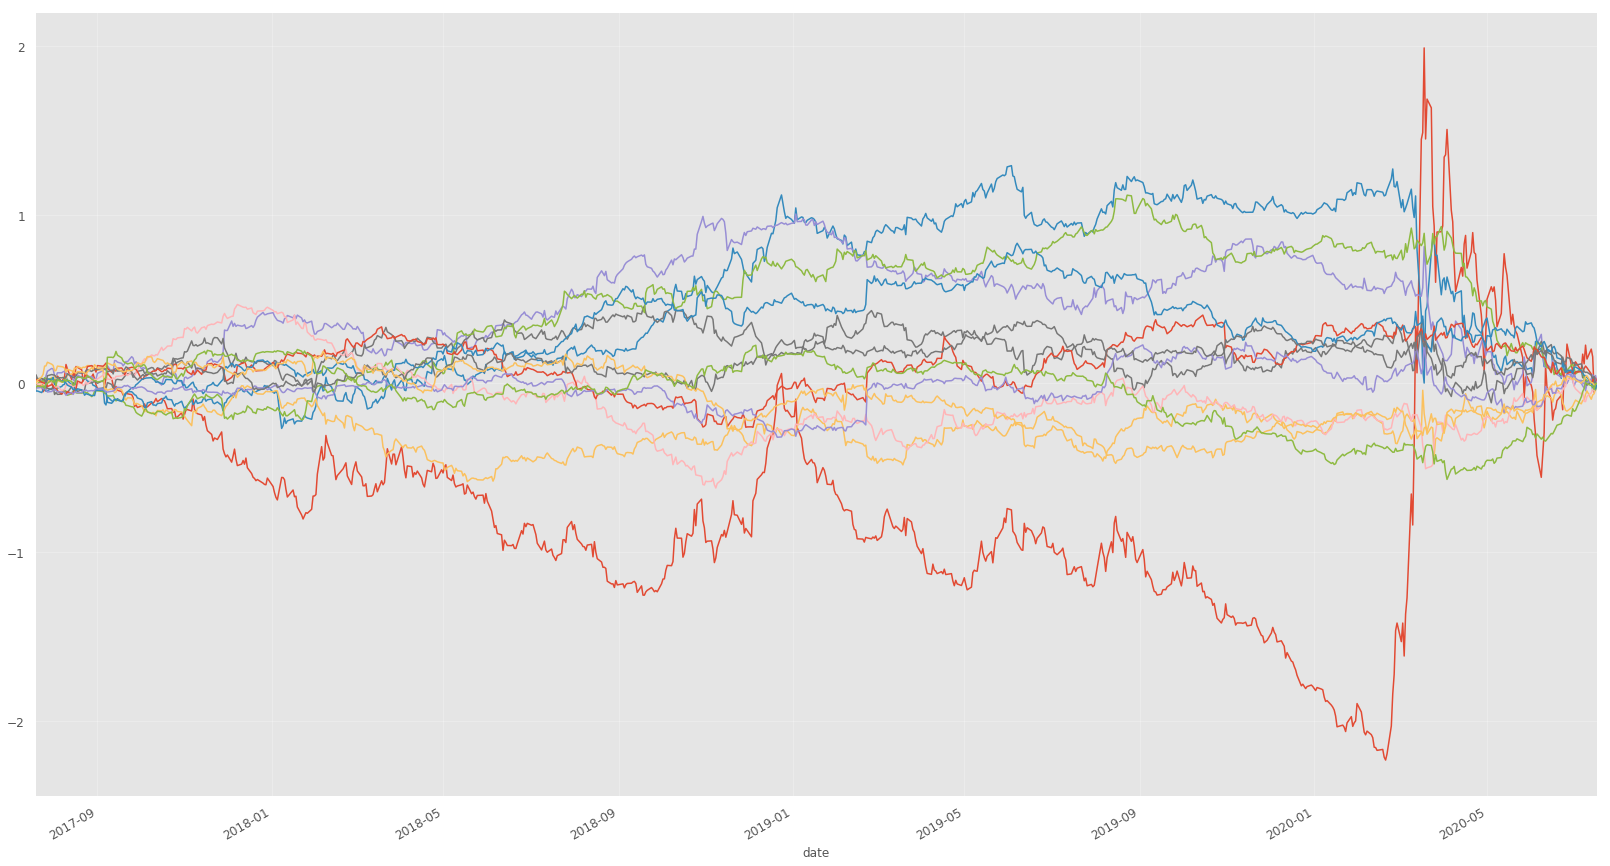

In [121]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[optimal_weights_regularized.index],num_factor_exposures=factor_exposures,weights=optimal_weights_regularized)

In [122]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 8.3 %


In [123]:
all_factors.to_csv('data/all_factors.csv')
close.to_csv('data/close.csv')
optimal_weights_regularized.to_csv('output/optimal_weights_regularized.csv')

In [124]:
import vlc
p = vlc.MediaPlayer("/home/k13104/Desktop/ES_PREL Whoosh Soft 7 - SFX Producer.mp3")
p.play()

0

In [125]:
print ('leverage is {}'.format(optimal_weights_regularized.abs().sum().round(2)[0]))
print ('long/short leverage balance is {}'.format(optimal_weights_regularized.sum().round(2)[0]))

leverage is 1.0
long/short leverage balance is 0.2


In [126]:
assert optimal_weights_regularized.sum().round(2)[0] == np.round((percent_long_leverage_target - percent_short_leverage_target),1)
assert optimal_weights_regularized.abs().sum().round(2)[0] == 1.0